In [17]:
import collections

import pyDNase
import tensorflow as tf
import h5py
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import kipoi
import os
import pybedtools
import torch
import h5sparse
import datetime
import logging

from pyDNase import GenomicInterval
from scipy.sparse import coo_matrix, vstack

from scipy.fftpack import fft, ifft

import sys

# Define Paths for this user

In [18]:
########################## PATHS ###########################
# path to where dnase bams are stored. Bams need to be sorted and indexed. See bin/download_dnase_encode.sh for
# data processing
_ENCODE_DATA_PREFIX =  "/data/akmorrow/encode_data/"

deepsea_path = "/data/akmorrow/epitome_data/deepsea_train/"
dnase_preprocessed_path = "/data/akmorrow/epitome_data/processed_dnase/"
feature_path = "/home/eecs/akmorrow/epitome/data/feature_name"

_DEEPSEA_GENOME_REGIONS_FILENAME = "/home/eecs/akmorrow/epitome/data/allTFs.pos.bed"

# DNase filepath dictionary
prefix_ =  "/data/akmorrow/encode_data/"


# get TF logger
log = logging.getLogger('tensorflow')
tf_log = "/home/eecs/akmorrow/epitome/dnase/tensorflow_combination.log"
fh = logging.FileHandler(tf_log)
fh.setLevel(logging.INFO)
log.addHandler(fh)

In [19]:
exec(open("./constants.py").read())
exec(open("./functions.py").read())

# Load Data

### Load DeepSEA data

In [4]:
train_data, valid_data, test_data = load_deepsea_data(deepsea_path)

print(valid_data["x"].shape, train_data["x"].shape, test_data["x"].shape)
print(valid_data["y"].shape, train_data["y"].shape, test_data["y"].shape)

(408000, 4, 1000) (4000000, 4, 1000) (455024, 4, 1000)
(919, 408000) (919, 4000000) (919, 455024)


### Load Cut Sites

In [5]:
### Load DNase data
dnase_train = h5sparse.File(os.path.join(dnase_preprocessed_path, "processed_dnase_train_sparse.h5"))
dnase_valid = h5sparse.File(os.path.join(dnase_preprocessed_path, "processed_dnase_valid_sparse.h5"))
dnase_test  = h5sparse.File(os.path.join(dnase_preprocessed_path, "processed_dnase_test_sparse.h5"))

In [6]:
%%time

# process cut sites to dictionary of (key: celltype, value: csr_matrix)
dnase_train_dict = toSparseIndexedDictionary(dnase_train, dnase_valid,dnase_test, Dataset.TRAIN)
dnase_valid_dict = toSparseIndexedDictionary(dnase_train, dnase_valid,dnase_test, Dataset.VALID)
dnase_test_dict = toSparseIndexedDictionary(dnase_train, dnase_valid,dnase_test, Dataset.TEST)

CPU times: user 8.53 s, sys: 9.52 s, total: 18 s
Wall time: 18.1 s


# Choose cell types

['K562', 'GM12878', 'H1-hESC', 'HepG2', 'HeLa-S3', 'A549', 'HUVEC', 'GM12891', 'MCF-7', 'GM12892', 'HCT-116'] ['DNase', 'CTCF', 'Pol2', 'YY1', 'p300', 'TAF1', 'Pol2-4H8', 'c-Myc', 'Rad21', 'Max', 'NRSF', 'GABP', 'EZH2', 'CEBPB', 'c-Jun', 'ZBTB33', 'USF2', 'USF-1', 'TBP', 'RFX5']


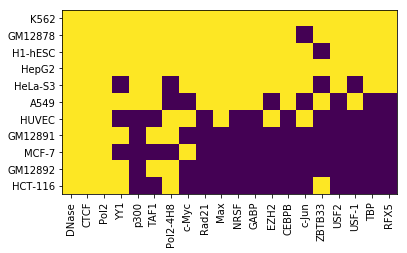

In [7]:
# matrix is cell types by factors, contains indices in feature vector
matrix, cellmap, assaymap = get_assays_from_feature_file()

inv_assaymap = {v: k for k, v in assaymap.items()}

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.xticks(np.arange(len(assaymap)), rotation = 90)
ax.set_xticklabels(assaymap.keys())
plt.yticks(np.arange(len(cellmap)))
ax.set_yticklabels(cellmap.keys())

plt.imshow(matrix!=-1)
print(list(cellmap.keys())[:11], list(assaymap.keys())[:20])

# Select train, valid and test cell types

- test on A549
- train/validate on K562 and HepG2
- use remaining cell types as feature input 

In [8]:
# A549 is for test. 12 available features
test_celltypes = ["A549"]

valid_y_indices = np.copy(matrix[cellmap['A549']])
# indices that are unavailable for A549
valid_holdout_indices = np.where(valid_y_indices == -1)[0]
# TODO: need the vectors to be the same length, but you should not evaluate on these
# Currently, set -1's to 0 these will all be evaluated on the DNase
valid_y_indices[matrix[cellmap['A549']] ==-1]=0

# K562, HepG2 indices is for train/valid. 19 available features
evaluation_celltypes = ["K562", "HepG2"] 
y_indices = [matrix[cellmap['K562']][matrix[cellmap['K562']]!=-1], 
             matrix[cellmap['HepG2']][matrix[cellmap['HepG2']]!=-1]]

# indices_mat is used to pull the remaining indices from cell types not used for prediction.
# delete evaluation cell types from the matrix (A549, HepG2 and K562)
indices_mat = np.delete(matrix, [0,3,5], axis=0)

# get all feature locations for DNase for remaining cell types (just the first column in matrix)
dnase_indices = indices_mat[:,0] # for all of the cell types (including the cell type we are evaluating)
indices = indices_mat[indices_mat!=-1]

# cell types not used in validation
train_celltypes = ['GM12878', 'H1-hESC', 'HeLa-S3', 'HUVEC', 'GM12891', 'MCF-7', 'GM12892', 'HCT-116']


# Data Generators

## Generator with just processed DNase

In [9]:

### Distance functions
def gen(data, DATA_LABEL, radii=[1,3]):
    def g():
        
        # determines which indices to use for labels
        if (DATA_LABEL == Dataset.TEST):
            y_index_vector = [valid_y_indices]
        else:
            y_index_vector = y_indices
            
        if (len(radii) > 0):
            range_ = range(max(radii), data["y"].shape[-1]-max(radii))
        else: 
            range_ = range(0, data["y"].shape[-1])
 
        for i in range_: # for all records
            for y_index in y_index_vector:
                dnases = [] 
                for radius in radii:
                    # within the radius, fraction of places where they are both 1
                    dnase_double_positive = np.average(data["y"][dnase_indices,i-radius:i+radius+1]*
                                             data["y"][y_index[0],i-radius:i+radius+1], axis=1)
                    
                    # within the radius, fraction of places where they are both equal (0 or 1)
                    dnase_agreement = np.average(data["y"][dnase_indices,i-radius:i+radius+1]==
                                             data["y"][y_index[0],i-radius:i+radius+1], axis=1)
                    dnases.extend(dnase_double_positive)
                    dnases.extend(dnase_agreement)
                    
                # Remove DNase from prediction indices. 
                # You should not predict on assays you use to calculate the distance metric.
                y_index_no_dnase = np.delete(y_index, [0])
                yield np.concatenate([data["y"][indices,i],dnases]), data["y"][y_index_no_dnase,i] 
    return g

def make_dataset(data,
                 which_dataset,
                 batch_size,
                 shuffle_size,
                 prefetch_size,
                 radii):

    generator = gen(data, which_dataset, radii)
    
    for x, y in generator():
        break
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32,)*2,
        output_shapes=(x.shape, y.shape,)
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(shuffle_size)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(prefetch_size)
    return y.shape, dataset.make_one_shot_iterator()


## Raw DNase Generator

In [36]:
def gen_dnase(data, DATA_LABEL, radii, chunk_size = 1):
    def g():
        # determines which indices to use for labels
        if (DATA_LABEL == Dataset.TEST):
            celltypes = test_celltypes
            y_index_vector = [valid_y_indices]
        else:
            celltypes = evaluation_celltypes
            y_index_vector = y_indices
            
            
        if (len(radii) > 0):
            start = max(radii)
            end = data["y"].shape[-1]-max(radii)
        else: 
            start = 0
            end = data["y"].shape[-1]
            range_ = range(start, end)

        start_ = start
        while (start_ < end):
            end_ = min(start + chunk_size, end)
            range_ = range(start_, end_)
            
            # for all cells in either train or test
            for cell_i in range(0, len(celltypes)): # for each y_index [K562, HepG2], or [A549] if test

                celltype = celltypes[cell_i]
                y_index = y_index_vector[cell_i]
 
                # get dnase for this cell type
                dnase_i = get_dnase_array_from_modified_dict(dnase_train_dict, dnase_valid_dict, dnase_test_dict,
                                                         range_,celltype, DATA_LABEL=DATA_LABEL)

                dnases = np.empty((len(range_), 0))

                # compare to all other cell types
                for train_celltype in train_celltypes: 

                    dnase_j = get_dnase_array_from_modified_dict(dnase_train_dict, dnase_valid_dict, dnase_test_dict, 
                                                            range_, train_celltype, DATA_LABEL=DATA_LABEL)

                    var_difference = abs(np.var(dnase_i.toarray(), axis=1) - np.var(dnase_j.toarray(), axis=1))
                    var_difference = np.reshape(var_difference, (-1,  1))
                    fft_mse = np.mean((fft(dnase_i.toarray(), axis=1) - fft(dnase_j.toarray(), axis=1))**2, axis=1).real

                    fft_mse = np.reshape(fft_mse, (-1,  1))
                    concat= np.concatenate((var_difference,fft_mse), axis=1)
                    dnases = np.append(dnases, concat, axis=1)

                # Remove DNase from prediction indices. 
                # You should not predict on assays you use to calculate the distance metric.
                y_index_no_dnase = np.delete(y_index, [0])

                for i in range(start_, end_):
                    yield np.concatenate([data["y"][indices,i].T,dnases[i,:]]), data["y"][y_index_no_dnase, i]
                
            start += chunk_size

    return g

def make_dataset_dnase(data,
                 which_dataset, # Dataset enum
                 batch_size,
                 shuffle_size,
                 prefetch_size,
                 radii):
    
    generator = gen_dnase(data, which_dataset, radii, chunk_size=50000)
    
    for x, y in generator():
        break
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32,)*2,
        output_shapes=(x.shape, y.shape,)
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(shuffle_size)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(prefetch_size)
    return y.shape, dataset.make_one_shot_iterator()




# Combination Generator

In [69]:
def gen_dnase_combination(data, DATA_LABEL, radii, chunk_size = 1):
    def g():
        # determines which indices to use for labels
        if (DATA_LABEL == Dataset.TEST):
            celltypes = test_celltypes
            y_index_vector = [valid_y_indices]
        else:
            celltypes = evaluation_celltypes
            y_index_vector = y_indices
            
            
        if (len(radii) > 0):
            start = max(radii)
            end = data["y"].shape[-1]-max(radii)
        else: 
            start = 0
            end = data["y"].shape[-1]
            range_ = range(start, end)

        start_ = start
        while (start_ < end):
            end_ = min(start_ + chunk_size, end)
            range_ = range(start_, end_)
            
            # for all cells in either train or test
            for cell_i in range(0, len(celltypes)): # for each y_index [K562, HepG2], or [A549] if test

                celltype = celltypes[cell_i]
                y_index = y_index_vector[cell_i]
 
                # get dnase for this cell type
                dnase_i = get_dnase_array_from_modified_dict(dnase_train_dict, dnase_valid_dict, dnase_test_dict,
                                                         range_,celltype, DATA_LABEL=DATA_LABEL)

                dnases = np.empty((len(range_), 0))

                # compare to all other cell types
                for train_celltype in train_celltypes: 

                    dnase_j = get_dnase_array_from_modified_dict(dnase_train_dict, dnase_valid_dict, dnase_test_dict, 
                                                            range_, train_celltype, DATA_LABEL=DATA_LABEL)

                    var_difference = abs(np.var(dnase_i.toarray(), axis=1) - np.var(dnase_j.toarray(), axis=1))
                    var_difference = np.reshape(var_difference, (-1,  1))
                    fft_mse = np.mean((fft(dnase_i.toarray(), axis=1) - fft(dnase_j.toarray(), axis=1))**2, axis=1).real

                    fft_mse = np.reshape(fft_mse, (-1,  1))
                    concat= np.concatenate((var_difference,fft_mse), axis=1)
                    dnases = np.append(dnases, concat, axis=1)

                
                # Remove DNase from prediction indices. 
                # You should not predict on assays you use to calculate the distance metric.
                y_index_no_dnase = np.delete(y_index, [0])

                for i in range(start_, end_):
                    
                    dnases_radii = [] 
                    for radius in radii:
                        # within the radius, fraction of places where they are both 1
                        dnase_double_positive = np.average(data["y"][dnase_indices,i-radius:i+radius+1]*
                                                 data["y"][y_index[0],i-radius:i+radius+1], axis=1)

                        # within the radius, fraction of places where they are both equal (0 or 1)
                        dnase_agreement = np.average(data["y"][dnase_indices,i-radius:i+radius+1]==
                                                 data["y"][y_index[0],i-radius:i+radius+1], axis=1)
                        dnases_radii.extend(dnase_double_positive)
                        dnases_radii.extend(dnase_agreement)

                    dnases_radii = np.array(dnases_radii)
                    
                    yield np.concatenate([data["y"][indices,i].T,dnases[i-start_,:], dnases_radii]), data["y"][y_index_no_dnase, i]
                
            start_ += chunk_size

    return g

def make_dataset_dnase_combination(data,
                 which_dataset, # Dataset enum
                 batch_size,
                 shuffle_size,
                 prefetch_size,
                 radii):
    
    generator = gen_dnase_combination(data, which_dataset, radii, chunk_size=50000)
    
    for x, y in generator():
        break
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32,)*2,
        output_shapes=(x.shape, y.shape,)
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(shuffle_size)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(prefetch_size)
    return y.shape, dataset.make_one_shot_iterator()




# Testing times for DNase generator

With DNase, it is about 30 times slower with chunk size of 200,000 :(

In [60]:
%%time 
generator = gen_dnase_combination(valid_data, Dataset.VALID, radii=[1,3,10,30], chunk_size=1000)()
x1=list(generator)

range(30, 1030)
30 30 dnases[i,:] (1000, 16)
31 30 dnases[i,:] (1000, 16)
32 30 dnases[i,:] (1000, 16)
33 30 dnases[i,:] (1000, 16)
34 30 dnases[i,:] (1000, 16)
35 30 dnases[i,:] (1000, 16)
36 30 dnases[i,:] (1000, 16)
37 30 dnases[i,:] (1000, 16)
38 30 dnases[i,:] (1000, 16)
39 30 dnases[i,:] (1000, 16)
40 30 dnases[i,:] (1000, 16)
41 30 dnases[i,:] (1000, 16)
42 30 dnases[i,:] (1000, 16)
43 30 dnases[i,:] (1000, 16)
44 30 dnases[i,:] (1000, 16)
45 30 dnases[i,:] (1000, 16)
46 30 dnases[i,:] (1000, 16)
47 30 dnases[i,:] (1000, 16)
48 30 dnases[i,:] (1000, 16)
49 30 dnases[i,:] (1000, 16)
50 30 dnases[i,:] (1000, 16)
51 30 dnases[i,:] (1000, 16)
52 30 dnases[i,:] (1000, 16)
53 30 dnases[i,:] (1000, 16)
54 30 dnases[i,:] (1000, 16)
55 30 dnases[i,:] (1000, 16)
56 30 dnases[i,:] (1000, 16)
57 30 dnases[i,:] (1000, 16)
58 30 dnases[i,:] (1000, 16)
59 30 dnases[i,:] (1000, 16)
60 30 dnases[i,:] (1000, 16)
61 30 dnases[i,:] (1000, 16)
62 30 dnases[i,:] (1000, 16)
63 30 dnases[i,:] (1000, 16

347 30 dnases[i,:] (1000, 16)
348 30 dnases[i,:] (1000, 16)
349 30 dnases[i,:] (1000, 16)
350 30 dnases[i,:] (1000, 16)
351 30 dnases[i,:] (1000, 16)
352 30 dnases[i,:] (1000, 16)
353 30 dnases[i,:] (1000, 16)
354 30 dnases[i,:] (1000, 16)
355 30 dnases[i,:] (1000, 16)
356 30 dnases[i,:] (1000, 16)
357 30 dnases[i,:] (1000, 16)
358 30 dnases[i,:] (1000, 16)
359 30 dnases[i,:] (1000, 16)
360 30 dnases[i,:] (1000, 16)
361 30 dnases[i,:] (1000, 16)
362 30 dnases[i,:] (1000, 16)
363 30 dnases[i,:] (1000, 16)
364 30 dnases[i,:] (1000, 16)
365 30 dnases[i,:] (1000, 16)
366 30 dnases[i,:] (1000, 16)
367 30 dnases[i,:] (1000, 16)
368 30 dnases[i,:] (1000, 16)
369 30 dnases[i,:] (1000, 16)
370 30 dnases[i,:] (1000, 16)
371 30 dnases[i,:] (1000, 16)
372 30 dnases[i,:] (1000, 16)
373 30 dnases[i,:] (1000, 16)
374 30 dnases[i,:] (1000, 16)
375 30 dnases[i,:] (1000, 16)
376 30 dnases[i,:] (1000, 16)
377 30 dnases[i,:] (1000, 16)
378 30 dnases[i,:] (1000, 16)
379 30 dnases[i,:] (1000, 16)
380 30 dna

641 30 dnases[i,:] (1000, 16)
642 30 dnases[i,:] (1000, 16)
643 30 dnases[i,:] (1000, 16)
644 30 dnases[i,:] (1000, 16)
645 30 dnases[i,:] (1000, 16)
646 30 dnases[i,:] (1000, 16)
647 30 dnases[i,:] (1000, 16)
648 30 dnases[i,:] (1000, 16)
649 30 dnases[i,:] (1000, 16)
650 30 dnases[i,:] (1000, 16)
651 30 dnases[i,:] (1000, 16)
652 30 dnases[i,:] (1000, 16)
653 30 dnases[i,:] (1000, 16)
654 30 dnases[i,:] (1000, 16)
655 30 dnases[i,:] (1000, 16)
656 30 dnases[i,:] (1000, 16)
657 30 dnases[i,:] (1000, 16)
658 30 dnases[i,:] (1000, 16)
659 30 dnases[i,:] (1000, 16)
660 30 dnases[i,:] (1000, 16)
661 30 dnases[i,:] (1000, 16)
662 30 dnases[i,:] (1000, 16)
663 30 dnases[i,:] (1000, 16)
664 30 dnases[i,:] (1000, 16)
665 30 dnases[i,:] (1000, 16)
666 30 dnases[i,:] (1000, 16)
667 30 dnases[i,:] (1000, 16)
668 30 dnases[i,:] (1000, 16)
669 30 dnases[i,:] (1000, 16)
670 30 dnases[i,:] (1000, 16)
671 30 dnases[i,:] (1000, 16)
672 30 dnases[i,:] (1000, 16)
673 30 dnases[i,:] (1000, 16)
674 30 dna

918 30 dnases[i,:] (1000, 16)
919 30 dnases[i,:] (1000, 16)
920 30 dnases[i,:] (1000, 16)
921 30 dnases[i,:] (1000, 16)
922 30 dnases[i,:] (1000, 16)
923 30 dnases[i,:] (1000, 16)
924 30 dnases[i,:] (1000, 16)
925 30 dnases[i,:] (1000, 16)
926 30 dnases[i,:] (1000, 16)
927 30 dnases[i,:] (1000, 16)
928 30 dnases[i,:] (1000, 16)
929 30 dnases[i,:] (1000, 16)
930 30 dnases[i,:] (1000, 16)
931 30 dnases[i,:] (1000, 16)
932 30 dnases[i,:] (1000, 16)
933 30 dnases[i,:] (1000, 16)
934 30 dnases[i,:] (1000, 16)
935 30 dnases[i,:] (1000, 16)
936 30 dnases[i,:] (1000, 16)
937 30 dnases[i,:] (1000, 16)
938 30 dnases[i,:] (1000, 16)
939 30 dnases[i,:] (1000, 16)
940 30 dnases[i,:] (1000, 16)
941 30 dnases[i,:] (1000, 16)
942 30 dnases[i,:] (1000, 16)
943 30 dnases[i,:] (1000, 16)
944 30 dnases[i,:] (1000, 16)
945 30 dnases[i,:] (1000, 16)
946 30 dnases[i,:] (1000, 16)
947 30 dnases[i,:] (1000, 16)
948 30 dnases[i,:] (1000, 16)
949 30 dnases[i,:] (1000, 16)
950 30 dnases[i,:] (1000, 16)
951 30 dna

362 30 dnases[i,:] (1000, 16)
363 30 dnases[i,:] (1000, 16)
364 30 dnases[i,:] (1000, 16)
365 30 dnases[i,:] (1000, 16)
366 30 dnases[i,:] (1000, 16)
367 30 dnases[i,:] (1000, 16)
368 30 dnases[i,:] (1000, 16)
369 30 dnases[i,:] (1000, 16)
370 30 dnases[i,:] (1000, 16)
371 30 dnases[i,:] (1000, 16)
372 30 dnases[i,:] (1000, 16)
373 30 dnases[i,:] (1000, 16)
374 30 dnases[i,:] (1000, 16)
375 30 dnases[i,:] (1000, 16)
376 30 dnases[i,:] (1000, 16)
377 30 dnases[i,:] (1000, 16)
378 30 dnases[i,:] (1000, 16)
379 30 dnases[i,:] (1000, 16)
380 30 dnases[i,:] (1000, 16)
381 30 dnases[i,:] (1000, 16)
382 30 dnases[i,:] (1000, 16)
383 30 dnases[i,:] (1000, 16)
384 30 dnases[i,:] (1000, 16)
385 30 dnases[i,:] (1000, 16)
386 30 dnases[i,:] (1000, 16)
387 30 dnases[i,:] (1000, 16)
388 30 dnases[i,:] (1000, 16)
389 30 dnases[i,:] (1000, 16)
390 30 dnases[i,:] (1000, 16)
391 30 dnases[i,:] (1000, 16)
392 30 dnases[i,:] (1000, 16)
393 30 dnases[i,:] (1000, 16)
394 30 dnases[i,:] (1000, 16)
395 30 dna

657 30 dnases[i,:] (1000, 16)
658 30 dnases[i,:] (1000, 16)
659 30 dnases[i,:] (1000, 16)
660 30 dnases[i,:] (1000, 16)
661 30 dnases[i,:] (1000, 16)
662 30 dnases[i,:] (1000, 16)
663 30 dnases[i,:] (1000, 16)
664 30 dnases[i,:] (1000, 16)
665 30 dnases[i,:] (1000, 16)
666 30 dnases[i,:] (1000, 16)
667 30 dnases[i,:] (1000, 16)
668 30 dnases[i,:] (1000, 16)
669 30 dnases[i,:] (1000, 16)
670 30 dnases[i,:] (1000, 16)
671 30 dnases[i,:] (1000, 16)
672 30 dnases[i,:] (1000, 16)
673 30 dnases[i,:] (1000, 16)
674 30 dnases[i,:] (1000, 16)
675 30 dnases[i,:] (1000, 16)
676 30 dnases[i,:] (1000, 16)
677 30 dnases[i,:] (1000, 16)
678 30 dnases[i,:] (1000, 16)
679 30 dnases[i,:] (1000, 16)
680 30 dnases[i,:] (1000, 16)
681 30 dnases[i,:] (1000, 16)
682 30 dnases[i,:] (1000, 16)
683 30 dnases[i,:] (1000, 16)
684 30 dnases[i,:] (1000, 16)
685 30 dnases[i,:] (1000, 16)
686 30 dnases[i,:] (1000, 16)
687 30 dnases[i,:] (1000, 16)
688 30 dnases[i,:] (1000, 16)
689 30 dnases[i,:] (1000, 16)
690 30 dna

range(1030, 2030)
1030 30 dnases[i,:] (1000, 16)
1031 30 dnases[i,:] (1000, 16)
1032 30 dnases[i,:] (1000, 16)
1033 30 dnases[i,:] (1000, 16)
1034 30 dnases[i,:] (1000, 16)
1035 30 dnases[i,:] (1000, 16)
1036 30 dnases[i,:] (1000, 16)
1037 30 dnases[i,:] (1000, 16)
1038 30 dnases[i,:] (1000, 16)
1039 30 dnases[i,:] (1000, 16)
1040 30 dnases[i,:] (1000, 16)
1041 30 dnases[i,:] (1000, 16)
1042 30 dnases[i,:] (1000, 16)
1043 30 dnases[i,:] (1000, 16)
1044 30 dnases[i,:] (1000, 16)
1045 30 dnases[i,:] (1000, 16)
1046 30 dnases[i,:] (1000, 16)
1047 30 dnases[i,:] (1000, 16)
1048 30 dnases[i,:] (1000, 16)
1049 30 dnases[i,:] (1000, 16)
1050 30 dnases[i,:] (1000, 16)
1051 30 dnases[i,:] (1000, 16)
1052 30 dnases[i,:] (1000, 16)
1053 30 dnases[i,:] (1000, 16)
1054 30 dnases[i,:] (1000, 16)
1055 30 dnases[i,:] (1000, 16)
1056 30 dnases[i,:] (1000, 16)
1057 30 dnases[i,:] (1000, 16)
1058 30 dnases[i,:] (1000, 16)
1059 30 dnases[i,:] (1000, 16)
1060 30 dnases[i,:] (1000, 16)
1061 30 dnases[i,:] (

1367 30 dnases[i,:] (1000, 16)
1368 30 dnases[i,:] (1000, 16)
1369 30 dnases[i,:] (1000, 16)
1370 30 dnases[i,:] (1000, 16)
1371 30 dnases[i,:] (1000, 16)
1372 30 dnases[i,:] (1000, 16)
1373 30 dnases[i,:] (1000, 16)
1374 30 dnases[i,:] (1000, 16)
1375 30 dnases[i,:] (1000, 16)
1376 30 dnases[i,:] (1000, 16)
1377 30 dnases[i,:] (1000, 16)
1378 30 dnases[i,:] (1000, 16)
1379 30 dnases[i,:] (1000, 16)
1380 30 dnases[i,:] (1000, 16)
1381 30 dnases[i,:] (1000, 16)
1382 30 dnases[i,:] (1000, 16)
1383 30 dnases[i,:] (1000, 16)
1384 30 dnases[i,:] (1000, 16)
1385 30 dnases[i,:] (1000, 16)
1386 30 dnases[i,:] (1000, 16)
1387 30 dnases[i,:] (1000, 16)
1388 30 dnases[i,:] (1000, 16)
1389 30 dnases[i,:] (1000, 16)
1390 30 dnases[i,:] (1000, 16)
1391 30 dnases[i,:] (1000, 16)
1392 30 dnases[i,:] (1000, 16)
1393 30 dnases[i,:] (1000, 16)
1394 30 dnases[i,:] (1000, 16)
1395 30 dnases[i,:] (1000, 16)
1396 30 dnases[i,:] (1000, 16)
1397 30 dnases[i,:] (1000, 16)
1398 30 dnases[i,:] (1000, 16)
1399 30 

1649 30 dnases[i,:] (1000, 16)
1650 30 dnases[i,:] (1000, 16)
1651 30 dnases[i,:] (1000, 16)
1652 30 dnases[i,:] (1000, 16)
1653 30 dnases[i,:] (1000, 16)
1654 30 dnases[i,:] (1000, 16)
1655 30 dnases[i,:] (1000, 16)
1656 30 dnases[i,:] (1000, 16)
1657 30 dnases[i,:] (1000, 16)
1658 30 dnases[i,:] (1000, 16)
1659 30 dnases[i,:] (1000, 16)
1660 30 dnases[i,:] (1000, 16)
1661 30 dnases[i,:] (1000, 16)
1662 30 dnases[i,:] (1000, 16)
1663 30 dnases[i,:] (1000, 16)
1664 30 dnases[i,:] (1000, 16)
1665 30 dnases[i,:] (1000, 16)
1666 30 dnases[i,:] (1000, 16)
1667 30 dnases[i,:] (1000, 16)
1668 30 dnases[i,:] (1000, 16)
1669 30 dnases[i,:] (1000, 16)
1670 30 dnases[i,:] (1000, 16)
1671 30 dnases[i,:] (1000, 16)
1672 30 dnases[i,:] (1000, 16)
1673 30 dnases[i,:] (1000, 16)
1674 30 dnases[i,:] (1000, 16)
1675 30 dnases[i,:] (1000, 16)
1676 30 dnases[i,:] (1000, 16)
1677 30 dnases[i,:] (1000, 16)
1678 30 dnases[i,:] (1000, 16)
1679 30 dnases[i,:] (1000, 16)
1680 30 dnases[i,:] (1000, 16)
1681 30 

1916 30 dnases[i,:] (1000, 16)
1917 30 dnases[i,:] (1000, 16)
1918 30 dnases[i,:] (1000, 16)
1919 30 dnases[i,:] (1000, 16)
1920 30 dnases[i,:] (1000, 16)
1921 30 dnases[i,:] (1000, 16)
1922 30 dnases[i,:] (1000, 16)
1923 30 dnases[i,:] (1000, 16)
1924 30 dnases[i,:] (1000, 16)
1925 30 dnases[i,:] (1000, 16)
1926 30 dnases[i,:] (1000, 16)
1927 30 dnases[i,:] (1000, 16)
1928 30 dnases[i,:] (1000, 16)
1929 30 dnases[i,:] (1000, 16)
1930 30 dnases[i,:] (1000, 16)
1931 30 dnases[i,:] (1000, 16)
1932 30 dnases[i,:] (1000, 16)
1933 30 dnases[i,:] (1000, 16)
1934 30 dnases[i,:] (1000, 16)
1935 30 dnases[i,:] (1000, 16)
1936 30 dnases[i,:] (1000, 16)
1937 30 dnases[i,:] (1000, 16)
1938 30 dnases[i,:] (1000, 16)
1939 30 dnases[i,:] (1000, 16)
1940 30 dnases[i,:] (1000, 16)
1941 30 dnases[i,:] (1000, 16)
1942 30 dnases[i,:] (1000, 16)
1943 30 dnases[i,:] (1000, 16)
1944 30 dnases[i,:] (1000, 16)
1945 30 dnases[i,:] (1000, 16)
1946 30 dnases[i,:] (1000, 16)
1947 30 dnases[i,:] (1000, 16)
1948 30 

1370 30 dnases[i,:] (1000, 16)
1371 30 dnases[i,:] (1000, 16)
1372 30 dnases[i,:] (1000, 16)
1373 30 dnases[i,:] (1000, 16)
1374 30 dnases[i,:] (1000, 16)
1375 30 dnases[i,:] (1000, 16)
1376 30 dnases[i,:] (1000, 16)
1377 30 dnases[i,:] (1000, 16)
1378 30 dnases[i,:] (1000, 16)
1379 30 dnases[i,:] (1000, 16)
1380 30 dnases[i,:] (1000, 16)
1381 30 dnases[i,:] (1000, 16)
1382 30 dnases[i,:] (1000, 16)
1383 30 dnases[i,:] (1000, 16)
1384 30 dnases[i,:] (1000, 16)
1385 30 dnases[i,:] (1000, 16)
1386 30 dnases[i,:] (1000, 16)
1387 30 dnases[i,:] (1000, 16)
1388 30 dnases[i,:] (1000, 16)
1389 30 dnases[i,:] (1000, 16)
1390 30 dnases[i,:] (1000, 16)
1391 30 dnases[i,:] (1000, 16)
1392 30 dnases[i,:] (1000, 16)
1393 30 dnases[i,:] (1000, 16)
1394 30 dnases[i,:] (1000, 16)
1395 30 dnases[i,:] (1000, 16)
1396 30 dnases[i,:] (1000, 16)
1397 30 dnases[i,:] (1000, 16)
1398 30 dnases[i,:] (1000, 16)
1399 30 dnases[i,:] (1000, 16)
1400 30 dnases[i,:] (1000, 16)
1401 30 dnases[i,:] (1000, 16)
1402 30 

1665 30 dnases[i,:] (1000, 16)
1666 30 dnases[i,:] (1000, 16)
1667 30 dnases[i,:] (1000, 16)
1668 30 dnases[i,:] (1000, 16)
1669 30 dnases[i,:] (1000, 16)
1670 30 dnases[i,:] (1000, 16)
1671 30 dnases[i,:] (1000, 16)
1672 30 dnases[i,:] (1000, 16)
1673 30 dnases[i,:] (1000, 16)
1674 30 dnases[i,:] (1000, 16)
1675 30 dnases[i,:] (1000, 16)
1676 30 dnases[i,:] (1000, 16)
1677 30 dnases[i,:] (1000, 16)
1678 30 dnases[i,:] (1000, 16)
1679 30 dnases[i,:] (1000, 16)
1680 30 dnases[i,:] (1000, 16)
1681 30 dnases[i,:] (1000, 16)
1682 30 dnases[i,:] (1000, 16)
1683 30 dnases[i,:] (1000, 16)
1684 30 dnases[i,:] (1000, 16)
1685 30 dnases[i,:] (1000, 16)
1686 30 dnases[i,:] (1000, 16)
1687 30 dnases[i,:] (1000, 16)
1688 30 dnases[i,:] (1000, 16)
1689 30 dnases[i,:] (1000, 16)
1690 30 dnases[i,:] (1000, 16)
1691 30 dnases[i,:] (1000, 16)
1692 30 dnases[i,:] (1000, 16)
1693 30 dnases[i,:] (1000, 16)
1694 30 dnases[i,:] (1000, 16)
1695 30 dnases[i,:] (1000, 16)
1696 30 dnases[i,:] (1000, 16)
1697 30 

1955 30 dnases[i,:] (1000, 16)
1956 30 dnases[i,:] (1000, 16)
1957 30 dnases[i,:] (1000, 16)
1958 30 dnases[i,:] (1000, 16)
1959 30 dnases[i,:] (1000, 16)
1960 30 dnases[i,:] (1000, 16)
1961 30 dnases[i,:] (1000, 16)
1962 30 dnases[i,:] (1000, 16)
1963 30 dnases[i,:] (1000, 16)
1964 30 dnases[i,:] (1000, 16)
1965 30 dnases[i,:] (1000, 16)
1966 30 dnases[i,:] (1000, 16)
1967 30 dnases[i,:] (1000, 16)
1968 30 dnases[i,:] (1000, 16)
1969 30 dnases[i,:] (1000, 16)
1970 30 dnases[i,:] (1000, 16)
1971 30 dnases[i,:] (1000, 16)
1972 30 dnases[i,:] (1000, 16)
1973 30 dnases[i,:] (1000, 16)
1974 30 dnases[i,:] (1000, 16)
1975 30 dnases[i,:] (1000, 16)
1976 30 dnases[i,:] (1000, 16)
1977 30 dnases[i,:] (1000, 16)
1978 30 dnases[i,:] (1000, 16)
1979 30 dnases[i,:] (1000, 16)
1980 30 dnases[i,:] (1000, 16)
1981 30 dnases[i,:] (1000, 16)
1982 30 dnases[i,:] (1000, 16)
1983 30 dnases[i,:] (1000, 16)
1984 30 dnases[i,:] (1000, 16)
1985 30 dnases[i,:] (1000, 16)
1986 30 dnases[i,:] (1000, 16)
1987 30 

2358 30 dnases[i,:] (1000, 16)
2359 30 dnases[i,:] (1000, 16)
2360 30 dnases[i,:] (1000, 16)
2361 30 dnases[i,:] (1000, 16)
2362 30 dnases[i,:] (1000, 16)
2363 30 dnases[i,:] (1000, 16)
2364 30 dnases[i,:] (1000, 16)
2365 30 dnases[i,:] (1000, 16)
2366 30 dnases[i,:] (1000, 16)
2367 30 dnases[i,:] (1000, 16)
2368 30 dnases[i,:] (1000, 16)
2369 30 dnases[i,:] (1000, 16)
2370 30 dnases[i,:] (1000, 16)
2371 30 dnases[i,:] (1000, 16)
2372 30 dnases[i,:] (1000, 16)
2373 30 dnases[i,:] (1000, 16)
2374 30 dnases[i,:] (1000, 16)
2375 30 dnases[i,:] (1000, 16)
2376 30 dnases[i,:] (1000, 16)
2377 30 dnases[i,:] (1000, 16)
2378 30 dnases[i,:] (1000, 16)
2379 30 dnases[i,:] (1000, 16)
2380 30 dnases[i,:] (1000, 16)
2381 30 dnases[i,:] (1000, 16)
2382 30 dnases[i,:] (1000, 16)
2383 30 dnases[i,:] (1000, 16)
2384 30 dnases[i,:] (1000, 16)
2385 30 dnases[i,:] (1000, 16)
2386 30 dnases[i,:] (1000, 16)
2387 30 dnases[i,:] (1000, 16)
2388 30 dnases[i,:] (1000, 16)
2389 30 dnases[i,:] (1000, 16)
2390 30 

2651 30 dnases[i,:] (1000, 16)
2652 30 dnases[i,:] (1000, 16)
2653 30 dnases[i,:] (1000, 16)
2654 30 dnases[i,:] (1000, 16)
2655 30 dnases[i,:] (1000, 16)
2656 30 dnases[i,:] (1000, 16)
2657 30 dnases[i,:] (1000, 16)
2658 30 dnases[i,:] (1000, 16)
2659 30 dnases[i,:] (1000, 16)
2660 30 dnases[i,:] (1000, 16)
2661 30 dnases[i,:] (1000, 16)
2662 30 dnases[i,:] (1000, 16)
2663 30 dnases[i,:] (1000, 16)
2664 30 dnases[i,:] (1000, 16)
2665 30 dnases[i,:] (1000, 16)
2666 30 dnases[i,:] (1000, 16)
2667 30 dnases[i,:] (1000, 16)
2668 30 dnases[i,:] (1000, 16)
2669 30 dnases[i,:] (1000, 16)
2670 30 dnases[i,:] (1000, 16)
2671 30 dnases[i,:] (1000, 16)
2672 30 dnases[i,:] (1000, 16)
2673 30 dnases[i,:] (1000, 16)
2674 30 dnases[i,:] (1000, 16)
2675 30 dnases[i,:] (1000, 16)
2676 30 dnases[i,:] (1000, 16)
2677 30 dnases[i,:] (1000, 16)
2678 30 dnases[i,:] (1000, 16)
2679 30 dnases[i,:] (1000, 16)
2680 30 dnases[i,:] (1000, 16)
2681 30 dnases[i,:] (1000, 16)
2682 30 dnases[i,:] (1000, 16)
2683 30 

range(2030, 3030)
2030 30 dnases[i,:] (1000, 16)
2031 30 dnases[i,:] (1000, 16)
2032 30 dnases[i,:] (1000, 16)
2033 30 dnases[i,:] (1000, 16)
2034 30 dnases[i,:] (1000, 16)
2035 30 dnases[i,:] (1000, 16)
2036 30 dnases[i,:] (1000, 16)
2037 30 dnases[i,:] (1000, 16)
2038 30 dnases[i,:] (1000, 16)
2039 30 dnases[i,:] (1000, 16)
2040 30 dnases[i,:] (1000, 16)
2041 30 dnases[i,:] (1000, 16)
2042 30 dnases[i,:] (1000, 16)
2043 30 dnases[i,:] (1000, 16)
2044 30 dnases[i,:] (1000, 16)
2045 30 dnases[i,:] (1000, 16)
2046 30 dnases[i,:] (1000, 16)
2047 30 dnases[i,:] (1000, 16)
2048 30 dnases[i,:] (1000, 16)
2049 30 dnases[i,:] (1000, 16)
2050 30 dnases[i,:] (1000, 16)
2051 30 dnases[i,:] (1000, 16)
2052 30 dnases[i,:] (1000, 16)
2053 30 dnases[i,:] (1000, 16)
2054 30 dnases[i,:] (1000, 16)
2055 30 dnases[i,:] (1000, 16)
2056 30 dnases[i,:] (1000, 16)
2057 30 dnases[i,:] (1000, 16)
2058 30 dnases[i,:] (1000, 16)
2059 30 dnases[i,:] (1000, 16)
2060 30 dnases[i,:] (1000, 16)
2061 30 dnases[i,:] (

2364 30 dnases[i,:] (1000, 16)
2365 30 dnases[i,:] (1000, 16)
2366 30 dnases[i,:] (1000, 16)
2367 30 dnases[i,:] (1000, 16)
2368 30 dnases[i,:] (1000, 16)
2369 30 dnases[i,:] (1000, 16)
2370 30 dnases[i,:] (1000, 16)
2371 30 dnases[i,:] (1000, 16)
2372 30 dnases[i,:] (1000, 16)
2373 30 dnases[i,:] (1000, 16)
2374 30 dnases[i,:] (1000, 16)
2375 30 dnases[i,:] (1000, 16)
2376 30 dnases[i,:] (1000, 16)
2377 30 dnases[i,:] (1000, 16)
2378 30 dnases[i,:] (1000, 16)
2379 30 dnases[i,:] (1000, 16)
2380 30 dnases[i,:] (1000, 16)
2381 30 dnases[i,:] (1000, 16)
2382 30 dnases[i,:] (1000, 16)
2383 30 dnases[i,:] (1000, 16)
2384 30 dnases[i,:] (1000, 16)
2385 30 dnases[i,:] (1000, 16)
2386 30 dnases[i,:] (1000, 16)
2387 30 dnases[i,:] (1000, 16)
2388 30 dnases[i,:] (1000, 16)
2389 30 dnases[i,:] (1000, 16)
2390 30 dnases[i,:] (1000, 16)
2391 30 dnases[i,:] (1000, 16)
2392 30 dnases[i,:] (1000, 16)
2393 30 dnases[i,:] (1000, 16)
2394 30 dnases[i,:] (1000, 16)
2395 30 dnases[i,:] (1000, 16)
2396 30 

2644 30 dnases[i,:] (1000, 16)
2645 30 dnases[i,:] (1000, 16)
2646 30 dnases[i,:] (1000, 16)
2647 30 dnases[i,:] (1000, 16)
2648 30 dnases[i,:] (1000, 16)
2649 30 dnases[i,:] (1000, 16)
2650 30 dnases[i,:] (1000, 16)
2651 30 dnases[i,:] (1000, 16)
2652 30 dnases[i,:] (1000, 16)
2653 30 dnases[i,:] (1000, 16)
2654 30 dnases[i,:] (1000, 16)
2655 30 dnases[i,:] (1000, 16)
2656 30 dnases[i,:] (1000, 16)
2657 30 dnases[i,:] (1000, 16)
2658 30 dnases[i,:] (1000, 16)
2659 30 dnases[i,:] (1000, 16)
2660 30 dnases[i,:] (1000, 16)
2661 30 dnases[i,:] (1000, 16)
2662 30 dnases[i,:] (1000, 16)
2663 30 dnases[i,:] (1000, 16)
2664 30 dnases[i,:] (1000, 16)
2665 30 dnases[i,:] (1000, 16)
2666 30 dnases[i,:] (1000, 16)
2667 30 dnases[i,:] (1000, 16)
2668 30 dnases[i,:] (1000, 16)
2669 30 dnases[i,:] (1000, 16)
2670 30 dnases[i,:] (1000, 16)
2671 30 dnases[i,:] (1000, 16)
2672 30 dnases[i,:] (1000, 16)
2673 30 dnases[i,:] (1000, 16)
2674 30 dnases[i,:] (1000, 16)
2675 30 dnases[i,:] (1000, 16)
2676 30 

2914 30 dnases[i,:] (1000, 16)
2915 30 dnases[i,:] (1000, 16)
2916 30 dnases[i,:] (1000, 16)
2917 30 dnases[i,:] (1000, 16)
2918 30 dnases[i,:] (1000, 16)
2919 30 dnases[i,:] (1000, 16)
2920 30 dnases[i,:] (1000, 16)
2921 30 dnases[i,:] (1000, 16)
2922 30 dnases[i,:] (1000, 16)
2923 30 dnases[i,:] (1000, 16)
2924 30 dnases[i,:] (1000, 16)
2925 30 dnases[i,:] (1000, 16)
2926 30 dnases[i,:] (1000, 16)
2927 30 dnases[i,:] (1000, 16)
2928 30 dnases[i,:] (1000, 16)
2929 30 dnases[i,:] (1000, 16)
2930 30 dnases[i,:] (1000, 16)
2931 30 dnases[i,:] (1000, 16)
2932 30 dnases[i,:] (1000, 16)
2933 30 dnases[i,:] (1000, 16)
2934 30 dnases[i,:] (1000, 16)
2935 30 dnases[i,:] (1000, 16)
2936 30 dnases[i,:] (1000, 16)
2937 30 dnases[i,:] (1000, 16)
2938 30 dnases[i,:] (1000, 16)
2939 30 dnases[i,:] (1000, 16)
2940 30 dnases[i,:] (1000, 16)
2941 30 dnases[i,:] (1000, 16)
2942 30 dnases[i,:] (1000, 16)
2943 30 dnases[i,:] (1000, 16)
2944 30 dnases[i,:] (1000, 16)
2945 30 dnases[i,:] (1000, 16)
2946 30 

3362 30 dnases[i,:] (1000, 16)
3363 30 dnases[i,:] (1000, 16)
3364 30 dnases[i,:] (1000, 16)
3365 30 dnases[i,:] (1000, 16)
3366 30 dnases[i,:] (1000, 16)
3367 30 dnases[i,:] (1000, 16)
3368 30 dnases[i,:] (1000, 16)
3369 30 dnases[i,:] (1000, 16)
3370 30 dnases[i,:] (1000, 16)
3371 30 dnases[i,:] (1000, 16)
3372 30 dnases[i,:] (1000, 16)
3373 30 dnases[i,:] (1000, 16)
3374 30 dnases[i,:] (1000, 16)
3375 30 dnases[i,:] (1000, 16)
3376 30 dnases[i,:] (1000, 16)
3377 30 dnases[i,:] (1000, 16)
3378 30 dnases[i,:] (1000, 16)
3379 30 dnases[i,:] (1000, 16)
3380 30 dnases[i,:] (1000, 16)
3381 30 dnases[i,:] (1000, 16)
3382 30 dnases[i,:] (1000, 16)
3383 30 dnases[i,:] (1000, 16)
3384 30 dnases[i,:] (1000, 16)
3385 30 dnases[i,:] (1000, 16)
3386 30 dnases[i,:] (1000, 16)
3387 30 dnases[i,:] (1000, 16)
3388 30 dnases[i,:] (1000, 16)
3389 30 dnases[i,:] (1000, 16)
3390 30 dnases[i,:] (1000, 16)
3391 30 dnases[i,:] (1000, 16)
3392 30 dnases[i,:] (1000, 16)
3393 30 dnases[i,:] (1000, 16)
3394 30 

3638 30 dnases[i,:] (1000, 16)
3639 30 dnases[i,:] (1000, 16)
3640 30 dnases[i,:] (1000, 16)
3641 30 dnases[i,:] (1000, 16)
3642 30 dnases[i,:] (1000, 16)
3643 30 dnases[i,:] (1000, 16)
3644 30 dnases[i,:] (1000, 16)
3645 30 dnases[i,:] (1000, 16)
3646 30 dnases[i,:] (1000, 16)
3647 30 dnases[i,:] (1000, 16)
3648 30 dnases[i,:] (1000, 16)
3649 30 dnases[i,:] (1000, 16)
3650 30 dnases[i,:] (1000, 16)
3651 30 dnases[i,:] (1000, 16)
3652 30 dnases[i,:] (1000, 16)
3653 30 dnases[i,:] (1000, 16)
3654 30 dnases[i,:] (1000, 16)
3655 30 dnases[i,:] (1000, 16)
3656 30 dnases[i,:] (1000, 16)
3657 30 dnases[i,:] (1000, 16)
3658 30 dnases[i,:] (1000, 16)
3659 30 dnases[i,:] (1000, 16)
3660 30 dnases[i,:] (1000, 16)
3661 30 dnases[i,:] (1000, 16)
3662 30 dnases[i,:] (1000, 16)
3663 30 dnases[i,:] (1000, 16)
3664 30 dnases[i,:] (1000, 16)
3665 30 dnases[i,:] (1000, 16)
3666 30 dnases[i,:] (1000, 16)
3667 30 dnases[i,:] (1000, 16)
3668 30 dnases[i,:] (1000, 16)
3669 30 dnases[i,:] (1000, 16)
3670 30 

3913 30 dnases[i,:] (1000, 16)
3914 30 dnases[i,:] (1000, 16)
3915 30 dnases[i,:] (1000, 16)
3916 30 dnases[i,:] (1000, 16)
3917 30 dnases[i,:] (1000, 16)
3918 30 dnases[i,:] (1000, 16)
3919 30 dnases[i,:] (1000, 16)
3920 30 dnases[i,:] (1000, 16)
3921 30 dnases[i,:] (1000, 16)
3922 30 dnases[i,:] (1000, 16)
3923 30 dnases[i,:] (1000, 16)
3924 30 dnases[i,:] (1000, 16)
3925 30 dnases[i,:] (1000, 16)
3926 30 dnases[i,:] (1000, 16)
3927 30 dnases[i,:] (1000, 16)
3928 30 dnases[i,:] (1000, 16)
3929 30 dnases[i,:] (1000, 16)
3930 30 dnases[i,:] (1000, 16)
3931 30 dnases[i,:] (1000, 16)
3932 30 dnases[i,:] (1000, 16)
3933 30 dnases[i,:] (1000, 16)
3934 30 dnases[i,:] (1000, 16)
3935 30 dnases[i,:] (1000, 16)
3936 30 dnases[i,:] (1000, 16)
3937 30 dnases[i,:] (1000, 16)
3938 30 dnases[i,:] (1000, 16)
3939 30 dnases[i,:] (1000, 16)
3940 30 dnases[i,:] (1000, 16)
3941 30 dnases[i,:] (1000, 16)
3942 30 dnases[i,:] (1000, 16)
3943 30 dnases[i,:] (1000, 16)
3944 30 dnases[i,:] (1000, 16)
3945 30 

3372 30 dnases[i,:] (1000, 16)
3373 30 dnases[i,:] (1000, 16)
3374 30 dnases[i,:] (1000, 16)
3375 30 dnases[i,:] (1000, 16)
3376 30 dnases[i,:] (1000, 16)
3377 30 dnases[i,:] (1000, 16)
3378 30 dnases[i,:] (1000, 16)
3379 30 dnases[i,:] (1000, 16)
3380 30 dnases[i,:] (1000, 16)
3381 30 dnases[i,:] (1000, 16)
3382 30 dnases[i,:] (1000, 16)
3383 30 dnases[i,:] (1000, 16)
3384 30 dnases[i,:] (1000, 16)
3385 30 dnases[i,:] (1000, 16)
3386 30 dnases[i,:] (1000, 16)
3387 30 dnases[i,:] (1000, 16)
3388 30 dnases[i,:] (1000, 16)
3389 30 dnases[i,:] (1000, 16)
3390 30 dnases[i,:] (1000, 16)
3391 30 dnases[i,:] (1000, 16)
3392 30 dnases[i,:] (1000, 16)
3393 30 dnases[i,:] (1000, 16)
3394 30 dnases[i,:] (1000, 16)
3395 30 dnases[i,:] (1000, 16)
3396 30 dnases[i,:] (1000, 16)
3397 30 dnases[i,:] (1000, 16)
3398 30 dnases[i,:] (1000, 16)
3399 30 dnases[i,:] (1000, 16)
3400 30 dnases[i,:] (1000, 16)
3401 30 dnases[i,:] (1000, 16)
3402 30 dnases[i,:] (1000, 16)
3403 30 dnases[i,:] (1000, 16)
3404 30 

3646 30 dnases[i,:] (1000, 16)
3647 30 dnases[i,:] (1000, 16)
3648 30 dnases[i,:] (1000, 16)
3649 30 dnases[i,:] (1000, 16)
3650 30 dnases[i,:] (1000, 16)
3651 30 dnases[i,:] (1000, 16)
3652 30 dnases[i,:] (1000, 16)
3653 30 dnases[i,:] (1000, 16)
3654 30 dnases[i,:] (1000, 16)
3655 30 dnases[i,:] (1000, 16)
3656 30 dnases[i,:] (1000, 16)
3657 30 dnases[i,:] (1000, 16)
3658 30 dnases[i,:] (1000, 16)
3659 30 dnases[i,:] (1000, 16)
3660 30 dnases[i,:] (1000, 16)
3661 30 dnases[i,:] (1000, 16)
3662 30 dnases[i,:] (1000, 16)
3663 30 dnases[i,:] (1000, 16)
3664 30 dnases[i,:] (1000, 16)
3665 30 dnases[i,:] (1000, 16)
3666 30 dnases[i,:] (1000, 16)
3667 30 dnases[i,:] (1000, 16)
3668 30 dnases[i,:] (1000, 16)
3669 30 dnases[i,:] (1000, 16)
3670 30 dnases[i,:] (1000, 16)
3671 30 dnases[i,:] (1000, 16)
3672 30 dnases[i,:] (1000, 16)
3673 30 dnases[i,:] (1000, 16)
3674 30 dnases[i,:] (1000, 16)
3675 30 dnases[i,:] (1000, 16)
3676 30 dnases[i,:] (1000, 16)
3677 30 dnases[i,:] (1000, 16)
3678 30 

3912 30 dnases[i,:] (1000, 16)
3913 30 dnases[i,:] (1000, 16)
3914 30 dnases[i,:] (1000, 16)
3915 30 dnases[i,:] (1000, 16)
3916 30 dnases[i,:] (1000, 16)
3917 30 dnases[i,:] (1000, 16)
3918 30 dnases[i,:] (1000, 16)
3919 30 dnases[i,:] (1000, 16)
3920 30 dnases[i,:] (1000, 16)
3921 30 dnases[i,:] (1000, 16)
3922 30 dnases[i,:] (1000, 16)
3923 30 dnases[i,:] (1000, 16)
3924 30 dnases[i,:] (1000, 16)
3925 30 dnases[i,:] (1000, 16)
3926 30 dnases[i,:] (1000, 16)
3927 30 dnases[i,:] (1000, 16)
3928 30 dnases[i,:] (1000, 16)
3929 30 dnases[i,:] (1000, 16)
3930 30 dnases[i,:] (1000, 16)
3931 30 dnases[i,:] (1000, 16)
3932 30 dnases[i,:] (1000, 16)
3933 30 dnases[i,:] (1000, 16)
3934 30 dnases[i,:] (1000, 16)
3935 30 dnases[i,:] (1000, 16)
3936 30 dnases[i,:] (1000, 16)
3937 30 dnases[i,:] (1000, 16)
3938 30 dnases[i,:] (1000, 16)
3939 30 dnases[i,:] (1000, 16)
3940 30 dnases[i,:] (1000, 16)
3941 30 dnases[i,:] (1000, 16)
3942 30 dnases[i,:] (1000, 16)
3943 30 dnases[i,:] (1000, 16)
3944 30 

4370 30 dnases[i,:] (1000, 16)
4371 30 dnases[i,:] (1000, 16)
4372 30 dnases[i,:] (1000, 16)
4373 30 dnases[i,:] (1000, 16)
4374 30 dnases[i,:] (1000, 16)
4375 30 dnases[i,:] (1000, 16)
4376 30 dnases[i,:] (1000, 16)
4377 30 dnases[i,:] (1000, 16)
4378 30 dnases[i,:] (1000, 16)
4379 30 dnases[i,:] (1000, 16)
4380 30 dnases[i,:] (1000, 16)
4381 30 dnases[i,:] (1000, 16)
4382 30 dnases[i,:] (1000, 16)
4383 30 dnases[i,:] (1000, 16)
4384 30 dnases[i,:] (1000, 16)
4385 30 dnases[i,:] (1000, 16)
4386 30 dnases[i,:] (1000, 16)
4387 30 dnases[i,:] (1000, 16)
4388 30 dnases[i,:] (1000, 16)
4389 30 dnases[i,:] (1000, 16)
4390 30 dnases[i,:] (1000, 16)
4391 30 dnases[i,:] (1000, 16)
4392 30 dnases[i,:] (1000, 16)
4393 30 dnases[i,:] (1000, 16)
4394 30 dnases[i,:] (1000, 16)
4395 30 dnases[i,:] (1000, 16)
4396 30 dnases[i,:] (1000, 16)
4397 30 dnases[i,:] (1000, 16)
4398 30 dnases[i,:] (1000, 16)
4399 30 dnases[i,:] (1000, 16)
4400 30 dnases[i,:] (1000, 16)
4401 30 dnases[i,:] (1000, 16)
4402 30 

4662 30 dnases[i,:] (1000, 16)
4663 30 dnases[i,:] (1000, 16)
4664 30 dnases[i,:] (1000, 16)
4665 30 dnases[i,:] (1000, 16)
4666 30 dnases[i,:] (1000, 16)
4667 30 dnases[i,:] (1000, 16)
4668 30 dnases[i,:] (1000, 16)
4669 30 dnases[i,:] (1000, 16)
4670 30 dnases[i,:] (1000, 16)
4671 30 dnases[i,:] (1000, 16)
4672 30 dnases[i,:] (1000, 16)
4673 30 dnases[i,:] (1000, 16)
4674 30 dnases[i,:] (1000, 16)
4675 30 dnases[i,:] (1000, 16)
4676 30 dnases[i,:] (1000, 16)
4677 30 dnases[i,:] (1000, 16)
4678 30 dnases[i,:] (1000, 16)
4679 30 dnases[i,:] (1000, 16)
4680 30 dnases[i,:] (1000, 16)
4681 30 dnases[i,:] (1000, 16)
4682 30 dnases[i,:] (1000, 16)
4683 30 dnases[i,:] (1000, 16)
4684 30 dnases[i,:] (1000, 16)
4685 30 dnases[i,:] (1000, 16)
4686 30 dnases[i,:] (1000, 16)
4687 30 dnases[i,:] (1000, 16)
4688 30 dnases[i,:] (1000, 16)
4689 30 dnases[i,:] (1000, 16)
4690 30 dnases[i,:] (1000, 16)
4691 30 dnases[i,:] (1000, 16)
4692 30 dnases[i,:] (1000, 16)
4693 30 dnases[i,:] (1000, 16)
4694 30 

4944 30 dnases[i,:] (1000, 16)
4945 30 dnases[i,:] (1000, 16)
4946 30 dnases[i,:] (1000, 16)
4947 30 dnases[i,:] (1000, 16)
4948 30 dnases[i,:] (1000, 16)
4949 30 dnases[i,:] (1000, 16)
4950 30 dnases[i,:] (1000, 16)
4951 30 dnases[i,:] (1000, 16)
4952 30 dnases[i,:] (1000, 16)
4953 30 dnases[i,:] (1000, 16)
4954 30 dnases[i,:] (1000, 16)
4955 30 dnases[i,:] (1000, 16)
4956 30 dnases[i,:] (1000, 16)
4957 30 dnases[i,:] (1000, 16)
4958 30 dnases[i,:] (1000, 16)
4959 30 dnases[i,:] (1000, 16)
4960 30 dnases[i,:] (1000, 16)
4961 30 dnases[i,:] (1000, 16)
4962 30 dnases[i,:] (1000, 16)
4963 30 dnases[i,:] (1000, 16)
4964 30 dnases[i,:] (1000, 16)
4965 30 dnases[i,:] (1000, 16)
4966 30 dnases[i,:] (1000, 16)
4967 30 dnases[i,:] (1000, 16)
4968 30 dnases[i,:] (1000, 16)
4969 30 dnases[i,:] (1000, 16)
4970 30 dnases[i,:] (1000, 16)
4971 30 dnases[i,:] (1000, 16)
4972 30 dnases[i,:] (1000, 16)
4973 30 dnases[i,:] (1000, 16)
4974 30 dnases[i,:] (1000, 16)
4975 30 dnases[i,:] (1000, 16)
4976 30 

4377 30 dnases[i,:] (1000, 16)
4378 30 dnases[i,:] (1000, 16)
4379 30 dnases[i,:] (1000, 16)
4380 30 dnases[i,:] (1000, 16)
4381 30 dnases[i,:] (1000, 16)
4382 30 dnases[i,:] (1000, 16)
4383 30 dnases[i,:] (1000, 16)
4384 30 dnases[i,:] (1000, 16)
4385 30 dnases[i,:] (1000, 16)
4386 30 dnases[i,:] (1000, 16)
4387 30 dnases[i,:] (1000, 16)
4388 30 dnases[i,:] (1000, 16)
4389 30 dnases[i,:] (1000, 16)
4390 30 dnases[i,:] (1000, 16)
4391 30 dnases[i,:] (1000, 16)
4392 30 dnases[i,:] (1000, 16)
4393 30 dnases[i,:] (1000, 16)
4394 30 dnases[i,:] (1000, 16)
4395 30 dnases[i,:] (1000, 16)
4396 30 dnases[i,:] (1000, 16)
4397 30 dnases[i,:] (1000, 16)
4398 30 dnases[i,:] (1000, 16)
4399 30 dnases[i,:] (1000, 16)
4400 30 dnases[i,:] (1000, 16)
4401 30 dnases[i,:] (1000, 16)
4402 30 dnases[i,:] (1000, 16)
4403 30 dnases[i,:] (1000, 16)
4404 30 dnases[i,:] (1000, 16)
4405 30 dnases[i,:] (1000, 16)
4406 30 dnases[i,:] (1000, 16)
4407 30 dnases[i,:] (1000, 16)
4408 30 dnases[i,:] (1000, 16)
4409 30 

4644 30 dnases[i,:] (1000, 16)
4645 30 dnases[i,:] (1000, 16)
4646 30 dnases[i,:] (1000, 16)
4647 30 dnases[i,:] (1000, 16)
4648 30 dnases[i,:] (1000, 16)
4649 30 dnases[i,:] (1000, 16)
4650 30 dnases[i,:] (1000, 16)
4651 30 dnases[i,:] (1000, 16)
4652 30 dnases[i,:] (1000, 16)
4653 30 dnases[i,:] (1000, 16)
4654 30 dnases[i,:] (1000, 16)
4655 30 dnases[i,:] (1000, 16)
4656 30 dnases[i,:] (1000, 16)
4657 30 dnases[i,:] (1000, 16)
4658 30 dnases[i,:] (1000, 16)
4659 30 dnases[i,:] (1000, 16)
4660 30 dnases[i,:] (1000, 16)
4661 30 dnases[i,:] (1000, 16)
4662 30 dnases[i,:] (1000, 16)
4663 30 dnases[i,:] (1000, 16)
4664 30 dnases[i,:] (1000, 16)
4665 30 dnases[i,:] (1000, 16)
4666 30 dnases[i,:] (1000, 16)
4667 30 dnases[i,:] (1000, 16)
4668 30 dnases[i,:] (1000, 16)
4669 30 dnases[i,:] (1000, 16)
4670 30 dnases[i,:] (1000, 16)
4671 30 dnases[i,:] (1000, 16)
4672 30 dnases[i,:] (1000, 16)
4673 30 dnases[i,:] (1000, 16)
4674 30 dnases[i,:] (1000, 16)
4675 30 dnases[i,:] (1000, 16)
4676 30 

4911 30 dnases[i,:] (1000, 16)
4912 30 dnases[i,:] (1000, 16)
4913 30 dnases[i,:] (1000, 16)
4914 30 dnases[i,:] (1000, 16)
4915 30 dnases[i,:] (1000, 16)
4916 30 dnases[i,:] (1000, 16)
4917 30 dnases[i,:] (1000, 16)
4918 30 dnases[i,:] (1000, 16)
4919 30 dnases[i,:] (1000, 16)
4920 30 dnases[i,:] (1000, 16)
4921 30 dnases[i,:] (1000, 16)
4922 30 dnases[i,:] (1000, 16)
4923 30 dnases[i,:] (1000, 16)
4924 30 dnases[i,:] (1000, 16)
4925 30 dnases[i,:] (1000, 16)
4926 30 dnases[i,:] (1000, 16)
4927 30 dnases[i,:] (1000, 16)
4928 30 dnases[i,:] (1000, 16)
4929 30 dnases[i,:] (1000, 16)
4930 30 dnases[i,:] (1000, 16)
4931 30 dnases[i,:] (1000, 16)
4932 30 dnases[i,:] (1000, 16)
4933 30 dnases[i,:] (1000, 16)
4934 30 dnases[i,:] (1000, 16)
4935 30 dnases[i,:] (1000, 16)
4936 30 dnases[i,:] (1000, 16)
4937 30 dnases[i,:] (1000, 16)
4938 30 dnases[i,:] (1000, 16)
4939 30 dnases[i,:] (1000, 16)
4940 30 dnases[i,:] (1000, 16)
4941 30 dnases[i,:] (1000, 16)
4942 30 dnases[i,:] (1000, 16)
4943 30 

5366 30 dnases[i,:] (1000, 16)
5367 30 dnases[i,:] (1000, 16)
5368 30 dnases[i,:] (1000, 16)
5369 30 dnases[i,:] (1000, 16)
5370 30 dnases[i,:] (1000, 16)
5371 30 dnases[i,:] (1000, 16)
5372 30 dnases[i,:] (1000, 16)
5373 30 dnases[i,:] (1000, 16)
5374 30 dnases[i,:] (1000, 16)
5375 30 dnases[i,:] (1000, 16)
5376 30 dnases[i,:] (1000, 16)
5377 30 dnases[i,:] (1000, 16)
5378 30 dnases[i,:] (1000, 16)
5379 30 dnases[i,:] (1000, 16)
5380 30 dnases[i,:] (1000, 16)
5381 30 dnases[i,:] (1000, 16)
5382 30 dnases[i,:] (1000, 16)
5383 30 dnases[i,:] (1000, 16)
5384 30 dnases[i,:] (1000, 16)
5385 30 dnases[i,:] (1000, 16)
5386 30 dnases[i,:] (1000, 16)
5387 30 dnases[i,:] (1000, 16)
5388 30 dnases[i,:] (1000, 16)
5389 30 dnases[i,:] (1000, 16)
5390 30 dnases[i,:] (1000, 16)
5391 30 dnases[i,:] (1000, 16)
5392 30 dnases[i,:] (1000, 16)
5393 30 dnases[i,:] (1000, 16)
5394 30 dnases[i,:] (1000, 16)
5395 30 dnases[i,:] (1000, 16)
5396 30 dnases[i,:] (1000, 16)
5397 30 dnases[i,:] (1000, 16)
5398 30 

5659 30 dnases[i,:] (1000, 16)
5660 30 dnases[i,:] (1000, 16)
5661 30 dnases[i,:] (1000, 16)
5662 30 dnases[i,:] (1000, 16)
5663 30 dnases[i,:] (1000, 16)
5664 30 dnases[i,:] (1000, 16)
5665 30 dnases[i,:] (1000, 16)
5666 30 dnases[i,:] (1000, 16)
5667 30 dnases[i,:] (1000, 16)
5668 30 dnases[i,:] (1000, 16)
5669 30 dnases[i,:] (1000, 16)
5670 30 dnases[i,:] (1000, 16)
5671 30 dnases[i,:] (1000, 16)
5672 30 dnases[i,:] (1000, 16)
5673 30 dnases[i,:] (1000, 16)
5674 30 dnases[i,:] (1000, 16)
5675 30 dnases[i,:] (1000, 16)
5676 30 dnases[i,:] (1000, 16)
5677 30 dnases[i,:] (1000, 16)
5678 30 dnases[i,:] (1000, 16)
5679 30 dnases[i,:] (1000, 16)
5680 30 dnases[i,:] (1000, 16)
5681 30 dnases[i,:] (1000, 16)
5682 30 dnases[i,:] (1000, 16)
5683 30 dnases[i,:] (1000, 16)
5684 30 dnases[i,:] (1000, 16)
5685 30 dnases[i,:] (1000, 16)
5686 30 dnases[i,:] (1000, 16)
5687 30 dnases[i,:] (1000, 16)
5688 30 dnases[i,:] (1000, 16)
5689 30 dnases[i,:] (1000, 16)
5690 30 dnases[i,:] (1000, 16)
5691 30 

5961 30 dnases[i,:] (1000, 16)
5962 30 dnases[i,:] (1000, 16)
5963 30 dnases[i,:] (1000, 16)
5964 30 dnases[i,:] (1000, 16)
5965 30 dnases[i,:] (1000, 16)
5966 30 dnases[i,:] (1000, 16)
5967 30 dnases[i,:] (1000, 16)
5968 30 dnases[i,:] (1000, 16)
5969 30 dnases[i,:] (1000, 16)
5970 30 dnases[i,:] (1000, 16)
5971 30 dnases[i,:] (1000, 16)
5972 30 dnases[i,:] (1000, 16)
5973 30 dnases[i,:] (1000, 16)
5974 30 dnases[i,:] (1000, 16)
5975 30 dnases[i,:] (1000, 16)
5976 30 dnases[i,:] (1000, 16)
5977 30 dnases[i,:] (1000, 16)
5978 30 dnases[i,:] (1000, 16)
5979 30 dnases[i,:] (1000, 16)
5980 30 dnases[i,:] (1000, 16)
5981 30 dnases[i,:] (1000, 16)
5982 30 dnases[i,:] (1000, 16)
5983 30 dnases[i,:] (1000, 16)
5984 30 dnases[i,:] (1000, 16)
5985 30 dnases[i,:] (1000, 16)
5986 30 dnases[i,:] (1000, 16)
5987 30 dnases[i,:] (1000, 16)
5988 30 dnases[i,:] (1000, 16)
5989 30 dnases[i,:] (1000, 16)
5990 30 dnases[i,:] (1000, 16)
5991 30 dnases[i,:] (1000, 16)
5992 30 dnases[i,:] (1000, 16)
5993 30 

5363 30 dnases[i,:] (1000, 16)
5364 30 dnases[i,:] (1000, 16)
5365 30 dnases[i,:] (1000, 16)
5366 30 dnases[i,:] (1000, 16)
5367 30 dnases[i,:] (1000, 16)
5368 30 dnases[i,:] (1000, 16)
5369 30 dnases[i,:] (1000, 16)
5370 30 dnases[i,:] (1000, 16)
5371 30 dnases[i,:] (1000, 16)
5372 30 dnases[i,:] (1000, 16)
5373 30 dnases[i,:] (1000, 16)
5374 30 dnases[i,:] (1000, 16)
5375 30 dnases[i,:] (1000, 16)
5376 30 dnases[i,:] (1000, 16)
5377 30 dnases[i,:] (1000, 16)
5378 30 dnases[i,:] (1000, 16)
5379 30 dnases[i,:] (1000, 16)
5380 30 dnases[i,:] (1000, 16)
5381 30 dnases[i,:] (1000, 16)
5382 30 dnases[i,:] (1000, 16)
5383 30 dnases[i,:] (1000, 16)
5384 30 dnases[i,:] (1000, 16)
5385 30 dnases[i,:] (1000, 16)
5386 30 dnases[i,:] (1000, 16)
5387 30 dnases[i,:] (1000, 16)
5388 30 dnases[i,:] (1000, 16)
5389 30 dnases[i,:] (1000, 16)
5390 30 dnases[i,:] (1000, 16)
5391 30 dnases[i,:] (1000, 16)
5392 30 dnases[i,:] (1000, 16)
5393 30 dnases[i,:] (1000, 16)
5394 30 dnases[i,:] (1000, 16)
5395 30 

5658 30 dnases[i,:] (1000, 16)
5659 30 dnases[i,:] (1000, 16)
5660 30 dnases[i,:] (1000, 16)
5661 30 dnases[i,:] (1000, 16)
5662 30 dnases[i,:] (1000, 16)
5663 30 dnases[i,:] (1000, 16)
5664 30 dnases[i,:] (1000, 16)
5665 30 dnases[i,:] (1000, 16)
5666 30 dnases[i,:] (1000, 16)
5667 30 dnases[i,:] (1000, 16)
5668 30 dnases[i,:] (1000, 16)
5669 30 dnases[i,:] (1000, 16)
5670 30 dnases[i,:] (1000, 16)
5671 30 dnases[i,:] (1000, 16)
5672 30 dnases[i,:] (1000, 16)
5673 30 dnases[i,:] (1000, 16)
5674 30 dnases[i,:] (1000, 16)
5675 30 dnases[i,:] (1000, 16)
5676 30 dnases[i,:] (1000, 16)
5677 30 dnases[i,:] (1000, 16)
5678 30 dnases[i,:] (1000, 16)
5679 30 dnases[i,:] (1000, 16)
5680 30 dnases[i,:] (1000, 16)
5681 30 dnases[i,:] (1000, 16)
5682 30 dnases[i,:] (1000, 16)
5683 30 dnases[i,:] (1000, 16)
5684 30 dnases[i,:] (1000, 16)
5685 30 dnases[i,:] (1000, 16)
5686 30 dnases[i,:] (1000, 16)
5687 30 dnases[i,:] (1000, 16)
5688 30 dnases[i,:] (1000, 16)
5689 30 dnases[i,:] (1000, 16)
5690 30 

range(6030, 7030)
6030 30 dnases[i,:] (1000, 16)
6031 30 dnases[i,:] (1000, 16)
6032 30 dnases[i,:] (1000, 16)
6033 30 dnases[i,:] (1000, 16)
6034 30 dnases[i,:] (1000, 16)
6035 30 dnases[i,:] (1000, 16)
6036 30 dnases[i,:] (1000, 16)
6037 30 dnases[i,:] (1000, 16)
6038 30 dnases[i,:] (1000, 16)
6039 30 dnases[i,:] (1000, 16)
6040 30 dnases[i,:] (1000, 16)
6041 30 dnases[i,:] (1000, 16)
6042 30 dnases[i,:] (1000, 16)
6043 30 dnases[i,:] (1000, 16)
6044 30 dnases[i,:] (1000, 16)
6045 30 dnases[i,:] (1000, 16)
6046 30 dnases[i,:] (1000, 16)
6047 30 dnases[i,:] (1000, 16)
6048 30 dnases[i,:] (1000, 16)
6049 30 dnases[i,:] (1000, 16)
6050 30 dnases[i,:] (1000, 16)
6051 30 dnases[i,:] (1000, 16)
6052 30 dnases[i,:] (1000, 16)
6053 30 dnases[i,:] (1000, 16)
6054 30 dnases[i,:] (1000, 16)
6055 30 dnases[i,:] (1000, 16)
6056 30 dnases[i,:] (1000, 16)
6057 30 dnases[i,:] (1000, 16)
6058 30 dnases[i,:] (1000, 16)
6059 30 dnases[i,:] (1000, 16)
6060 30 dnases[i,:] (1000, 16)
6061 30 dnases[i,:] (

6363 30 dnases[i,:] (1000, 16)
6364 30 dnases[i,:] (1000, 16)
6365 30 dnases[i,:] (1000, 16)
6366 30 dnases[i,:] (1000, 16)
6367 30 dnases[i,:] (1000, 16)
6368 30 dnases[i,:] (1000, 16)
6369 30 dnases[i,:] (1000, 16)
6370 30 dnases[i,:] (1000, 16)
6371 30 dnases[i,:] (1000, 16)
6372 30 dnases[i,:] (1000, 16)
6373 30 dnases[i,:] (1000, 16)
6374 30 dnases[i,:] (1000, 16)
6375 30 dnases[i,:] (1000, 16)
6376 30 dnases[i,:] (1000, 16)
6377 30 dnases[i,:] (1000, 16)
6378 30 dnases[i,:] (1000, 16)
6379 30 dnases[i,:] (1000, 16)
6380 30 dnases[i,:] (1000, 16)
6381 30 dnases[i,:] (1000, 16)
6382 30 dnases[i,:] (1000, 16)
6383 30 dnases[i,:] (1000, 16)
6384 30 dnases[i,:] (1000, 16)
6385 30 dnases[i,:] (1000, 16)
6386 30 dnases[i,:] (1000, 16)
6387 30 dnases[i,:] (1000, 16)
6388 30 dnases[i,:] (1000, 16)
6389 30 dnases[i,:] (1000, 16)
6390 30 dnases[i,:] (1000, 16)
6391 30 dnases[i,:] (1000, 16)
6392 30 dnases[i,:] (1000, 16)
6393 30 dnases[i,:] (1000, 16)
6394 30 dnases[i,:] (1000, 16)
6395 30 

6657 30 dnases[i,:] (1000, 16)
6658 30 dnases[i,:] (1000, 16)
6659 30 dnases[i,:] (1000, 16)
6660 30 dnases[i,:] (1000, 16)
6661 30 dnases[i,:] (1000, 16)
6662 30 dnases[i,:] (1000, 16)
6663 30 dnases[i,:] (1000, 16)
6664 30 dnases[i,:] (1000, 16)
6665 30 dnases[i,:] (1000, 16)
6666 30 dnases[i,:] (1000, 16)
6667 30 dnases[i,:] (1000, 16)
6668 30 dnases[i,:] (1000, 16)
6669 30 dnases[i,:] (1000, 16)
6670 30 dnases[i,:] (1000, 16)
6671 30 dnases[i,:] (1000, 16)
6672 30 dnases[i,:] (1000, 16)
6673 30 dnases[i,:] (1000, 16)
6674 30 dnases[i,:] (1000, 16)
6675 30 dnases[i,:] (1000, 16)
6676 30 dnases[i,:] (1000, 16)
6677 30 dnases[i,:] (1000, 16)
6678 30 dnases[i,:] (1000, 16)
6679 30 dnases[i,:] (1000, 16)
6680 30 dnases[i,:] (1000, 16)
6681 30 dnases[i,:] (1000, 16)
6682 30 dnases[i,:] (1000, 16)
6683 30 dnases[i,:] (1000, 16)
6684 30 dnases[i,:] (1000, 16)
6685 30 dnases[i,:] (1000, 16)
6686 30 dnases[i,:] (1000, 16)
6687 30 dnases[i,:] (1000, 16)
6688 30 dnases[i,:] (1000, 16)
6689 30 

range(6030, 7030)
6030 30 dnases[i,:] (1000, 16)
6031 30 dnases[i,:] (1000, 16)
6032 30 dnases[i,:] (1000, 16)
6033 30 dnases[i,:] (1000, 16)
6034 30 dnases[i,:] (1000, 16)
6035 30 dnases[i,:] (1000, 16)
6036 30 dnases[i,:] (1000, 16)
6037 30 dnases[i,:] (1000, 16)
6038 30 dnases[i,:] (1000, 16)
6039 30 dnases[i,:] (1000, 16)
6040 30 dnases[i,:] (1000, 16)
6041 30 dnases[i,:] (1000, 16)
6042 30 dnases[i,:] (1000, 16)
6043 30 dnases[i,:] (1000, 16)
6044 30 dnases[i,:] (1000, 16)
6045 30 dnases[i,:] (1000, 16)
6046 30 dnases[i,:] (1000, 16)
6047 30 dnases[i,:] (1000, 16)
6048 30 dnases[i,:] (1000, 16)
6049 30 dnases[i,:] (1000, 16)
6050 30 dnases[i,:] (1000, 16)
6051 30 dnases[i,:] (1000, 16)
6052 30 dnases[i,:] (1000, 16)
6053 30 dnases[i,:] (1000, 16)
6054 30 dnases[i,:] (1000, 16)
6055 30 dnases[i,:] (1000, 16)
6056 30 dnases[i,:] (1000, 16)
6057 30 dnases[i,:] (1000, 16)
6058 30 dnases[i,:] (1000, 16)
6059 30 dnases[i,:] (1000, 16)
6060 30 dnases[i,:] (1000, 16)
6061 30 dnases[i,:] (

6370 30 dnases[i,:] (1000, 16)
6371 30 dnases[i,:] (1000, 16)
6372 30 dnases[i,:] (1000, 16)
6373 30 dnases[i,:] (1000, 16)
6374 30 dnases[i,:] (1000, 16)
6375 30 dnases[i,:] (1000, 16)
6376 30 dnases[i,:] (1000, 16)
6377 30 dnases[i,:] (1000, 16)
6378 30 dnases[i,:] (1000, 16)
6379 30 dnases[i,:] (1000, 16)
6380 30 dnases[i,:] (1000, 16)
6381 30 dnases[i,:] (1000, 16)
6382 30 dnases[i,:] (1000, 16)
6383 30 dnases[i,:] (1000, 16)
6384 30 dnases[i,:] (1000, 16)
6385 30 dnases[i,:] (1000, 16)
6386 30 dnases[i,:] (1000, 16)
6387 30 dnases[i,:] (1000, 16)
6388 30 dnases[i,:] (1000, 16)
6389 30 dnases[i,:] (1000, 16)
6390 30 dnases[i,:] (1000, 16)
6391 30 dnases[i,:] (1000, 16)
6392 30 dnases[i,:] (1000, 16)
6393 30 dnases[i,:] (1000, 16)
6394 30 dnases[i,:] (1000, 16)
6395 30 dnases[i,:] (1000, 16)
6396 30 dnases[i,:] (1000, 16)
6397 30 dnases[i,:] (1000, 16)
6398 30 dnases[i,:] (1000, 16)
6399 30 dnases[i,:] (1000, 16)
6400 30 dnases[i,:] (1000, 16)
6401 30 dnases[i,:] (1000, 16)
6402 30 

6658 30 dnases[i,:] (1000, 16)
6659 30 dnases[i,:] (1000, 16)
6660 30 dnases[i,:] (1000, 16)
6661 30 dnases[i,:] (1000, 16)
6662 30 dnases[i,:] (1000, 16)
6663 30 dnases[i,:] (1000, 16)
6664 30 dnases[i,:] (1000, 16)
6665 30 dnases[i,:] (1000, 16)
6666 30 dnases[i,:] (1000, 16)
6667 30 dnases[i,:] (1000, 16)
6668 30 dnases[i,:] (1000, 16)
6669 30 dnases[i,:] (1000, 16)
6670 30 dnases[i,:] (1000, 16)
6671 30 dnases[i,:] (1000, 16)
6672 30 dnases[i,:] (1000, 16)
6673 30 dnases[i,:] (1000, 16)
6674 30 dnases[i,:] (1000, 16)
6675 30 dnases[i,:] (1000, 16)
6676 30 dnases[i,:] (1000, 16)
6677 30 dnases[i,:] (1000, 16)
6678 30 dnases[i,:] (1000, 16)
6679 30 dnases[i,:] (1000, 16)
6680 30 dnases[i,:] (1000, 16)
6681 30 dnases[i,:] (1000, 16)
6682 30 dnases[i,:] (1000, 16)
6683 30 dnases[i,:] (1000, 16)
6684 30 dnases[i,:] (1000, 16)
6685 30 dnases[i,:] (1000, 16)
6686 30 dnases[i,:] (1000, 16)
6687 30 dnases[i,:] (1000, 16)
6688 30 dnases[i,:] (1000, 16)
6689 30 dnases[i,:] (1000, 16)
6690 30 

6967 30 dnases[i,:] (1000, 16)
6968 30 dnases[i,:] (1000, 16)
6969 30 dnases[i,:] (1000, 16)
6970 30 dnases[i,:] (1000, 16)
6971 30 dnases[i,:] (1000, 16)
6972 30 dnases[i,:] (1000, 16)
6973 30 dnases[i,:] (1000, 16)
6974 30 dnases[i,:] (1000, 16)
6975 30 dnases[i,:] (1000, 16)
6976 30 dnases[i,:] (1000, 16)
6977 30 dnases[i,:] (1000, 16)
6978 30 dnases[i,:] (1000, 16)
6979 30 dnases[i,:] (1000, 16)
6980 30 dnases[i,:] (1000, 16)
6981 30 dnases[i,:] (1000, 16)
6982 30 dnases[i,:] (1000, 16)
6983 30 dnases[i,:] (1000, 16)
6984 30 dnases[i,:] (1000, 16)
6985 30 dnases[i,:] (1000, 16)
6986 30 dnases[i,:] (1000, 16)
6987 30 dnases[i,:] (1000, 16)
6988 30 dnases[i,:] (1000, 16)
6989 30 dnases[i,:] (1000, 16)
6990 30 dnases[i,:] (1000, 16)
6991 30 dnases[i,:] (1000, 16)
6992 30 dnases[i,:] (1000, 16)
6993 30 dnases[i,:] (1000, 16)
6994 30 dnases[i,:] (1000, 16)
6995 30 dnases[i,:] (1000, 16)
6996 30 dnases[i,:] (1000, 16)
6997 30 dnases[i,:] (1000, 16)
6998 30 dnases[i,:] (1000, 16)
6999 30 

7367 30 dnases[i,:] (1000, 16)
7368 30 dnases[i,:] (1000, 16)
7369 30 dnases[i,:] (1000, 16)
7370 30 dnases[i,:] (1000, 16)
7371 30 dnases[i,:] (1000, 16)
7372 30 dnases[i,:] (1000, 16)
7373 30 dnases[i,:] (1000, 16)
7374 30 dnases[i,:] (1000, 16)
7375 30 dnases[i,:] (1000, 16)
7376 30 dnases[i,:] (1000, 16)
7377 30 dnases[i,:] (1000, 16)
7378 30 dnases[i,:] (1000, 16)
7379 30 dnases[i,:] (1000, 16)
7380 30 dnases[i,:] (1000, 16)
7381 30 dnases[i,:] (1000, 16)
7382 30 dnases[i,:] (1000, 16)
7383 30 dnases[i,:] (1000, 16)
7384 30 dnases[i,:] (1000, 16)
7385 30 dnases[i,:] (1000, 16)
7386 30 dnases[i,:] (1000, 16)
7387 30 dnases[i,:] (1000, 16)
7388 30 dnases[i,:] (1000, 16)
7389 30 dnases[i,:] (1000, 16)
7390 30 dnases[i,:] (1000, 16)
7391 30 dnases[i,:] (1000, 16)
7392 30 dnases[i,:] (1000, 16)
7393 30 dnases[i,:] (1000, 16)
7394 30 dnases[i,:] (1000, 16)
7395 30 dnases[i,:] (1000, 16)
7396 30 dnases[i,:] (1000, 16)
7397 30 dnases[i,:] (1000, 16)
7398 30 dnases[i,:] (1000, 16)
7399 30 

7657 30 dnases[i,:] (1000, 16)
7658 30 dnases[i,:] (1000, 16)
7659 30 dnases[i,:] (1000, 16)
7660 30 dnases[i,:] (1000, 16)
7661 30 dnases[i,:] (1000, 16)
7662 30 dnases[i,:] (1000, 16)
7663 30 dnases[i,:] (1000, 16)
7664 30 dnases[i,:] (1000, 16)
7665 30 dnases[i,:] (1000, 16)
7666 30 dnases[i,:] (1000, 16)
7667 30 dnases[i,:] (1000, 16)
7668 30 dnases[i,:] (1000, 16)
7669 30 dnases[i,:] (1000, 16)
7670 30 dnases[i,:] (1000, 16)
7671 30 dnases[i,:] (1000, 16)
7672 30 dnases[i,:] (1000, 16)
7673 30 dnases[i,:] (1000, 16)
7674 30 dnases[i,:] (1000, 16)
7675 30 dnases[i,:] (1000, 16)
7676 30 dnases[i,:] (1000, 16)
7677 30 dnases[i,:] (1000, 16)
7678 30 dnases[i,:] (1000, 16)
7679 30 dnases[i,:] (1000, 16)
7680 30 dnases[i,:] (1000, 16)
7681 30 dnases[i,:] (1000, 16)
7682 30 dnases[i,:] (1000, 16)
7683 30 dnases[i,:] (1000, 16)
7684 30 dnases[i,:] (1000, 16)
7685 30 dnases[i,:] (1000, 16)
7686 30 dnases[i,:] (1000, 16)
7687 30 dnases[i,:] (1000, 16)
7688 30 dnases[i,:] (1000, 16)
7689 30 

7956 30 dnases[i,:] (1000, 16)
7957 30 dnases[i,:] (1000, 16)
7958 30 dnases[i,:] (1000, 16)
7959 30 dnases[i,:] (1000, 16)
7960 30 dnases[i,:] (1000, 16)
7961 30 dnases[i,:] (1000, 16)
7962 30 dnases[i,:] (1000, 16)
7963 30 dnases[i,:] (1000, 16)
7964 30 dnases[i,:] (1000, 16)
7965 30 dnases[i,:] (1000, 16)
7966 30 dnases[i,:] (1000, 16)
7967 30 dnases[i,:] (1000, 16)
7968 30 dnases[i,:] (1000, 16)
7969 30 dnases[i,:] (1000, 16)
7970 30 dnases[i,:] (1000, 16)
7971 30 dnases[i,:] (1000, 16)
7972 30 dnases[i,:] (1000, 16)
7973 30 dnases[i,:] (1000, 16)
7974 30 dnases[i,:] (1000, 16)
7975 30 dnases[i,:] (1000, 16)
7976 30 dnases[i,:] (1000, 16)
7977 30 dnases[i,:] (1000, 16)
7978 30 dnases[i,:] (1000, 16)
7979 30 dnases[i,:] (1000, 16)
7980 30 dnases[i,:] (1000, 16)
7981 30 dnases[i,:] (1000, 16)
7982 30 dnases[i,:] (1000, 16)
7983 30 dnases[i,:] (1000, 16)
7984 30 dnases[i,:] (1000, 16)
7985 30 dnases[i,:] (1000, 16)
7986 30 dnases[i,:] (1000, 16)
7987 30 dnases[i,:] (1000, 16)
7988 30 

7376 30 dnases[i,:] (1000, 16)
7377 30 dnases[i,:] (1000, 16)
7378 30 dnases[i,:] (1000, 16)
7379 30 dnases[i,:] (1000, 16)
7380 30 dnases[i,:] (1000, 16)
7381 30 dnases[i,:] (1000, 16)
7382 30 dnases[i,:] (1000, 16)
7383 30 dnases[i,:] (1000, 16)
7384 30 dnases[i,:] (1000, 16)
7385 30 dnases[i,:] (1000, 16)
7386 30 dnases[i,:] (1000, 16)
7387 30 dnases[i,:] (1000, 16)
7388 30 dnases[i,:] (1000, 16)
7389 30 dnases[i,:] (1000, 16)
7390 30 dnases[i,:] (1000, 16)
7391 30 dnases[i,:] (1000, 16)
7392 30 dnases[i,:] (1000, 16)
7393 30 dnases[i,:] (1000, 16)
7394 30 dnases[i,:] (1000, 16)
7395 30 dnases[i,:] (1000, 16)
7396 30 dnases[i,:] (1000, 16)
7397 30 dnases[i,:] (1000, 16)
7398 30 dnases[i,:] (1000, 16)
7399 30 dnases[i,:] (1000, 16)
7400 30 dnases[i,:] (1000, 16)
7401 30 dnases[i,:] (1000, 16)
7402 30 dnases[i,:] (1000, 16)
7403 30 dnases[i,:] (1000, 16)
7404 30 dnases[i,:] (1000, 16)
7405 30 dnases[i,:] (1000, 16)
7406 30 dnases[i,:] (1000, 16)
7407 30 dnases[i,:] (1000, 16)
7408 30 

7657 30 dnases[i,:] (1000, 16)
7658 30 dnases[i,:] (1000, 16)
7659 30 dnases[i,:] (1000, 16)
7660 30 dnases[i,:] (1000, 16)
7661 30 dnases[i,:] (1000, 16)
7662 30 dnases[i,:] (1000, 16)
7663 30 dnases[i,:] (1000, 16)
7664 30 dnases[i,:] (1000, 16)
7665 30 dnases[i,:] (1000, 16)
7666 30 dnases[i,:] (1000, 16)
7667 30 dnases[i,:] (1000, 16)
7668 30 dnases[i,:] (1000, 16)
7669 30 dnases[i,:] (1000, 16)
7670 30 dnases[i,:] (1000, 16)
7671 30 dnases[i,:] (1000, 16)
7672 30 dnases[i,:] (1000, 16)
7673 30 dnases[i,:] (1000, 16)
7674 30 dnases[i,:] (1000, 16)
7675 30 dnases[i,:] (1000, 16)
7676 30 dnases[i,:] (1000, 16)
7677 30 dnases[i,:] (1000, 16)
7678 30 dnases[i,:] (1000, 16)
7679 30 dnases[i,:] (1000, 16)
7680 30 dnases[i,:] (1000, 16)
7681 30 dnases[i,:] (1000, 16)
7682 30 dnases[i,:] (1000, 16)
7683 30 dnases[i,:] (1000, 16)
7684 30 dnases[i,:] (1000, 16)
7685 30 dnases[i,:] (1000, 16)
7686 30 dnases[i,:] (1000, 16)
7687 30 dnases[i,:] (1000, 16)
7688 30 dnases[i,:] (1000, 16)
7689 30 

7955 30 dnases[i,:] (1000, 16)
7956 30 dnases[i,:] (1000, 16)
7957 30 dnases[i,:] (1000, 16)
7958 30 dnases[i,:] (1000, 16)
7959 30 dnases[i,:] (1000, 16)
7960 30 dnases[i,:] (1000, 16)
7961 30 dnases[i,:] (1000, 16)
7962 30 dnases[i,:] (1000, 16)
7963 30 dnases[i,:] (1000, 16)
7964 30 dnases[i,:] (1000, 16)
7965 30 dnases[i,:] (1000, 16)
7966 30 dnases[i,:] (1000, 16)
7967 30 dnases[i,:] (1000, 16)
7968 30 dnases[i,:] (1000, 16)
7969 30 dnases[i,:] (1000, 16)
7970 30 dnases[i,:] (1000, 16)
7971 30 dnases[i,:] (1000, 16)
7972 30 dnases[i,:] (1000, 16)
7973 30 dnases[i,:] (1000, 16)
7974 30 dnases[i,:] (1000, 16)
7975 30 dnases[i,:] (1000, 16)
7976 30 dnases[i,:] (1000, 16)
7977 30 dnases[i,:] (1000, 16)
7978 30 dnases[i,:] (1000, 16)
7979 30 dnases[i,:] (1000, 16)
7980 30 dnases[i,:] (1000, 16)
7981 30 dnases[i,:] (1000, 16)
7982 30 dnases[i,:] (1000, 16)
7983 30 dnases[i,:] (1000, 16)
7984 30 dnases[i,:] (1000, 16)
7985 30 dnases[i,:] (1000, 16)
7986 30 dnases[i,:] (1000, 16)
7987 30 

8381 30 dnases[i,:] (1000, 16)
8382 30 dnases[i,:] (1000, 16)
8383 30 dnases[i,:] (1000, 16)
8384 30 dnases[i,:] (1000, 16)
8385 30 dnases[i,:] (1000, 16)
8386 30 dnases[i,:] (1000, 16)
8387 30 dnases[i,:] (1000, 16)
8388 30 dnases[i,:] (1000, 16)
8389 30 dnases[i,:] (1000, 16)
8390 30 dnases[i,:] (1000, 16)
8391 30 dnases[i,:] (1000, 16)
8392 30 dnases[i,:] (1000, 16)
8393 30 dnases[i,:] (1000, 16)
8394 30 dnases[i,:] (1000, 16)
8395 30 dnases[i,:] (1000, 16)
8396 30 dnases[i,:] (1000, 16)
8397 30 dnases[i,:] (1000, 16)
8398 30 dnases[i,:] (1000, 16)
8399 30 dnases[i,:] (1000, 16)
8400 30 dnases[i,:] (1000, 16)
8401 30 dnases[i,:] (1000, 16)
8402 30 dnases[i,:] (1000, 16)
8403 30 dnases[i,:] (1000, 16)
8404 30 dnases[i,:] (1000, 16)
8405 30 dnases[i,:] (1000, 16)
8406 30 dnases[i,:] (1000, 16)
8407 30 dnases[i,:] (1000, 16)
8408 30 dnases[i,:] (1000, 16)
8409 30 dnases[i,:] (1000, 16)
8410 30 dnases[i,:] (1000, 16)
8411 30 dnases[i,:] (1000, 16)
8412 30 dnases[i,:] (1000, 16)
8413 30 

8656 30 dnases[i,:] (1000, 16)
8657 30 dnases[i,:] (1000, 16)
8658 30 dnases[i,:] (1000, 16)
8659 30 dnases[i,:] (1000, 16)
8660 30 dnases[i,:] (1000, 16)
8661 30 dnases[i,:] (1000, 16)
8662 30 dnases[i,:] (1000, 16)
8663 30 dnases[i,:] (1000, 16)
8664 30 dnases[i,:] (1000, 16)
8665 30 dnases[i,:] (1000, 16)
8666 30 dnases[i,:] (1000, 16)
8667 30 dnases[i,:] (1000, 16)
8668 30 dnases[i,:] (1000, 16)
8669 30 dnases[i,:] (1000, 16)
8670 30 dnases[i,:] (1000, 16)
8671 30 dnases[i,:] (1000, 16)
8672 30 dnases[i,:] (1000, 16)
8673 30 dnases[i,:] (1000, 16)
8674 30 dnases[i,:] (1000, 16)
8675 30 dnases[i,:] (1000, 16)
8676 30 dnases[i,:] (1000, 16)
8677 30 dnases[i,:] (1000, 16)
8678 30 dnases[i,:] (1000, 16)
8679 30 dnases[i,:] (1000, 16)
8680 30 dnases[i,:] (1000, 16)
8681 30 dnases[i,:] (1000, 16)
8682 30 dnases[i,:] (1000, 16)
8683 30 dnases[i,:] (1000, 16)
8684 30 dnases[i,:] (1000, 16)
8685 30 dnases[i,:] (1000, 16)
8686 30 dnases[i,:] (1000, 16)
8687 30 dnases[i,:] (1000, 16)
8688 30 

8959 30 dnases[i,:] (1000, 16)
8960 30 dnases[i,:] (1000, 16)
8961 30 dnases[i,:] (1000, 16)
8962 30 dnases[i,:] (1000, 16)
8963 30 dnases[i,:] (1000, 16)
8964 30 dnases[i,:] (1000, 16)
8965 30 dnases[i,:] (1000, 16)
8966 30 dnases[i,:] (1000, 16)
8967 30 dnases[i,:] (1000, 16)
8968 30 dnases[i,:] (1000, 16)
8969 30 dnases[i,:] (1000, 16)
8970 30 dnases[i,:] (1000, 16)
8971 30 dnases[i,:] (1000, 16)
8972 30 dnases[i,:] (1000, 16)
8973 30 dnases[i,:] (1000, 16)
8974 30 dnases[i,:] (1000, 16)
8975 30 dnases[i,:] (1000, 16)
8976 30 dnases[i,:] (1000, 16)
8977 30 dnases[i,:] (1000, 16)
8978 30 dnases[i,:] (1000, 16)
8979 30 dnases[i,:] (1000, 16)
8980 30 dnases[i,:] (1000, 16)
8981 30 dnases[i,:] (1000, 16)
8982 30 dnases[i,:] (1000, 16)
8983 30 dnases[i,:] (1000, 16)
8984 30 dnases[i,:] (1000, 16)
8985 30 dnases[i,:] (1000, 16)
8986 30 dnases[i,:] (1000, 16)
8987 30 dnases[i,:] (1000, 16)
8988 30 dnases[i,:] (1000, 16)
8989 30 dnases[i,:] (1000, 16)
8990 30 dnases[i,:] (1000, 16)
8991 30 

8349 30 dnases[i,:] (1000, 16)
8350 30 dnases[i,:] (1000, 16)
8351 30 dnases[i,:] (1000, 16)
8352 30 dnases[i,:] (1000, 16)
8353 30 dnases[i,:] (1000, 16)
8354 30 dnases[i,:] (1000, 16)
8355 30 dnases[i,:] (1000, 16)
8356 30 dnases[i,:] (1000, 16)
8357 30 dnases[i,:] (1000, 16)
8358 30 dnases[i,:] (1000, 16)
8359 30 dnases[i,:] (1000, 16)
8360 30 dnases[i,:] (1000, 16)
8361 30 dnases[i,:] (1000, 16)
8362 30 dnases[i,:] (1000, 16)
8363 30 dnases[i,:] (1000, 16)
8364 30 dnases[i,:] (1000, 16)
8365 30 dnases[i,:] (1000, 16)
8366 30 dnases[i,:] (1000, 16)
8367 30 dnases[i,:] (1000, 16)
8368 30 dnases[i,:] (1000, 16)
8369 30 dnases[i,:] (1000, 16)
8370 30 dnases[i,:] (1000, 16)
8371 30 dnases[i,:] (1000, 16)
8372 30 dnases[i,:] (1000, 16)
8373 30 dnases[i,:] (1000, 16)
8374 30 dnases[i,:] (1000, 16)
8375 30 dnases[i,:] (1000, 16)
8376 30 dnases[i,:] (1000, 16)
8377 30 dnases[i,:] (1000, 16)
8378 30 dnases[i,:] (1000, 16)
8379 30 dnases[i,:] (1000, 16)
8380 30 dnases[i,:] (1000, 16)
8381 30 

8632 30 dnases[i,:] (1000, 16)
8633 30 dnases[i,:] (1000, 16)
8634 30 dnases[i,:] (1000, 16)
8635 30 dnases[i,:] (1000, 16)
8636 30 dnases[i,:] (1000, 16)
8637 30 dnases[i,:] (1000, 16)
8638 30 dnases[i,:] (1000, 16)
8639 30 dnases[i,:] (1000, 16)
8640 30 dnases[i,:] (1000, 16)
8641 30 dnases[i,:] (1000, 16)
8642 30 dnases[i,:] (1000, 16)
8643 30 dnases[i,:] (1000, 16)
8644 30 dnases[i,:] (1000, 16)
8645 30 dnases[i,:] (1000, 16)
8646 30 dnases[i,:] (1000, 16)
8647 30 dnases[i,:] (1000, 16)
8648 30 dnases[i,:] (1000, 16)
8649 30 dnases[i,:] (1000, 16)
8650 30 dnases[i,:] (1000, 16)
8651 30 dnases[i,:] (1000, 16)
8652 30 dnases[i,:] (1000, 16)
8653 30 dnases[i,:] (1000, 16)
8654 30 dnases[i,:] (1000, 16)
8655 30 dnases[i,:] (1000, 16)
8656 30 dnases[i,:] (1000, 16)
8657 30 dnases[i,:] (1000, 16)
8658 30 dnases[i,:] (1000, 16)
8659 30 dnases[i,:] (1000, 16)
8660 30 dnases[i,:] (1000, 16)
8661 30 dnases[i,:] (1000, 16)
8662 30 dnases[i,:] (1000, 16)
8663 30 dnases[i,:] (1000, 16)
8664 30 

8905 30 dnases[i,:] (1000, 16)
8906 30 dnases[i,:] (1000, 16)
8907 30 dnases[i,:] (1000, 16)
8908 30 dnases[i,:] (1000, 16)
8909 30 dnases[i,:] (1000, 16)
8910 30 dnases[i,:] (1000, 16)
8911 30 dnases[i,:] (1000, 16)
8912 30 dnases[i,:] (1000, 16)
8913 30 dnases[i,:] (1000, 16)
8914 30 dnases[i,:] (1000, 16)
8915 30 dnases[i,:] (1000, 16)
8916 30 dnases[i,:] (1000, 16)
8917 30 dnases[i,:] (1000, 16)
8918 30 dnases[i,:] (1000, 16)
8919 30 dnases[i,:] (1000, 16)
8920 30 dnases[i,:] (1000, 16)
8921 30 dnases[i,:] (1000, 16)
8922 30 dnases[i,:] (1000, 16)
8923 30 dnases[i,:] (1000, 16)
8924 30 dnases[i,:] (1000, 16)
8925 30 dnases[i,:] (1000, 16)
8926 30 dnases[i,:] (1000, 16)
8927 30 dnases[i,:] (1000, 16)
8928 30 dnases[i,:] (1000, 16)
8929 30 dnases[i,:] (1000, 16)
8930 30 dnases[i,:] (1000, 16)
8931 30 dnases[i,:] (1000, 16)
8932 30 dnases[i,:] (1000, 16)
8933 30 dnases[i,:] (1000, 16)
8934 30 dnases[i,:] (1000, 16)
8935 30 dnases[i,:] (1000, 16)
8936 30 dnases[i,:] (1000, 16)
8937 30 

9351 30 dnases[i,:] (1000, 16)
9352 30 dnases[i,:] (1000, 16)
9353 30 dnases[i,:] (1000, 16)
9354 30 dnases[i,:] (1000, 16)
9355 30 dnases[i,:] (1000, 16)
9356 30 dnases[i,:] (1000, 16)
9357 30 dnases[i,:] (1000, 16)
9358 30 dnases[i,:] (1000, 16)
9359 30 dnases[i,:] (1000, 16)
9360 30 dnases[i,:] (1000, 16)
9361 30 dnases[i,:] (1000, 16)
9362 30 dnases[i,:] (1000, 16)
9363 30 dnases[i,:] (1000, 16)
9364 30 dnases[i,:] (1000, 16)
9365 30 dnases[i,:] (1000, 16)
9366 30 dnases[i,:] (1000, 16)
9367 30 dnases[i,:] (1000, 16)
9368 30 dnases[i,:] (1000, 16)
9369 30 dnases[i,:] (1000, 16)
9370 30 dnases[i,:] (1000, 16)
9371 30 dnases[i,:] (1000, 16)
9372 30 dnases[i,:] (1000, 16)
9373 30 dnases[i,:] (1000, 16)
9374 30 dnases[i,:] (1000, 16)
9375 30 dnases[i,:] (1000, 16)
9376 30 dnases[i,:] (1000, 16)
9377 30 dnases[i,:] (1000, 16)
9378 30 dnases[i,:] (1000, 16)
9379 30 dnases[i,:] (1000, 16)
9380 30 dnases[i,:] (1000, 16)
9381 30 dnases[i,:] (1000, 16)
9382 30 dnases[i,:] (1000, 16)
9383 30 

9641 30 dnases[i,:] (1000, 16)
9642 30 dnases[i,:] (1000, 16)
9643 30 dnases[i,:] (1000, 16)
9644 30 dnases[i,:] (1000, 16)
9645 30 dnases[i,:] (1000, 16)
9646 30 dnases[i,:] (1000, 16)
9647 30 dnases[i,:] (1000, 16)
9648 30 dnases[i,:] (1000, 16)
9649 30 dnases[i,:] (1000, 16)
9650 30 dnases[i,:] (1000, 16)
9651 30 dnases[i,:] (1000, 16)
9652 30 dnases[i,:] (1000, 16)
9653 30 dnases[i,:] (1000, 16)
9654 30 dnases[i,:] (1000, 16)
9655 30 dnases[i,:] (1000, 16)
9656 30 dnases[i,:] (1000, 16)
9657 30 dnases[i,:] (1000, 16)
9658 30 dnases[i,:] (1000, 16)
9659 30 dnases[i,:] (1000, 16)
9660 30 dnases[i,:] (1000, 16)
9661 30 dnases[i,:] (1000, 16)
9662 30 dnases[i,:] (1000, 16)
9663 30 dnases[i,:] (1000, 16)
9664 30 dnases[i,:] (1000, 16)
9665 30 dnases[i,:] (1000, 16)
9666 30 dnases[i,:] (1000, 16)
9667 30 dnases[i,:] (1000, 16)
9668 30 dnases[i,:] (1000, 16)
9669 30 dnases[i,:] (1000, 16)
9670 30 dnases[i,:] (1000, 16)
9671 30 dnases[i,:] (1000, 16)
9672 30 dnases[i,:] (1000, 16)
9673 30 

range(9030, 10030)
9030 30 dnases[i,:] (1000, 16)
9031 30 dnases[i,:] (1000, 16)
9032 30 dnases[i,:] (1000, 16)
9033 30 dnases[i,:] (1000, 16)
9034 30 dnases[i,:] (1000, 16)
9035 30 dnases[i,:] (1000, 16)
9036 30 dnases[i,:] (1000, 16)
9037 30 dnases[i,:] (1000, 16)
9038 30 dnases[i,:] (1000, 16)
9039 30 dnases[i,:] (1000, 16)
9040 30 dnases[i,:] (1000, 16)
9041 30 dnases[i,:] (1000, 16)
9042 30 dnases[i,:] (1000, 16)
9043 30 dnases[i,:] (1000, 16)
9044 30 dnases[i,:] (1000, 16)
9045 30 dnases[i,:] (1000, 16)
9046 30 dnases[i,:] (1000, 16)
9047 30 dnases[i,:] (1000, 16)
9048 30 dnases[i,:] (1000, 16)
9049 30 dnases[i,:] (1000, 16)
9050 30 dnases[i,:] (1000, 16)
9051 30 dnases[i,:] (1000, 16)
9052 30 dnases[i,:] (1000, 16)
9053 30 dnases[i,:] (1000, 16)
9054 30 dnases[i,:] (1000, 16)
9055 30 dnases[i,:] (1000, 16)
9056 30 dnases[i,:] (1000, 16)
9057 30 dnases[i,:] (1000, 16)
9058 30 dnases[i,:] (1000, 16)
9059 30 dnases[i,:] (1000, 16)
9060 30 dnases[i,:] (1000, 16)
9061 30 dnases[i,:] 

9365 30 dnases[i,:] (1000, 16)
9366 30 dnases[i,:] (1000, 16)
9367 30 dnases[i,:] (1000, 16)
9368 30 dnases[i,:] (1000, 16)
9369 30 dnases[i,:] (1000, 16)
9370 30 dnases[i,:] (1000, 16)
9371 30 dnases[i,:] (1000, 16)
9372 30 dnases[i,:] (1000, 16)
9373 30 dnases[i,:] (1000, 16)
9374 30 dnases[i,:] (1000, 16)
9375 30 dnases[i,:] (1000, 16)
9376 30 dnases[i,:] (1000, 16)
9377 30 dnases[i,:] (1000, 16)
9378 30 dnases[i,:] (1000, 16)
9379 30 dnases[i,:] (1000, 16)
9380 30 dnases[i,:] (1000, 16)
9381 30 dnases[i,:] (1000, 16)
9382 30 dnases[i,:] (1000, 16)
9383 30 dnases[i,:] (1000, 16)
9384 30 dnases[i,:] (1000, 16)
9385 30 dnases[i,:] (1000, 16)
9386 30 dnases[i,:] (1000, 16)
9387 30 dnases[i,:] (1000, 16)
9388 30 dnases[i,:] (1000, 16)
9389 30 dnases[i,:] (1000, 16)
9390 30 dnases[i,:] (1000, 16)
9391 30 dnases[i,:] (1000, 16)
9392 30 dnases[i,:] (1000, 16)
9393 30 dnases[i,:] (1000, 16)
9394 30 dnases[i,:] (1000, 16)
9395 30 dnases[i,:] (1000, 16)
9396 30 dnases[i,:] (1000, 16)
9397 30 

9654 30 dnases[i,:] (1000, 16)
9655 30 dnases[i,:] (1000, 16)
9656 30 dnases[i,:] (1000, 16)
9657 30 dnases[i,:] (1000, 16)
9658 30 dnases[i,:] (1000, 16)
9659 30 dnases[i,:] (1000, 16)
9660 30 dnases[i,:] (1000, 16)
9661 30 dnases[i,:] (1000, 16)
9662 30 dnases[i,:] (1000, 16)
9663 30 dnases[i,:] (1000, 16)
9664 30 dnases[i,:] (1000, 16)
9665 30 dnases[i,:] (1000, 16)
9666 30 dnases[i,:] (1000, 16)
9667 30 dnases[i,:] (1000, 16)
9668 30 dnases[i,:] (1000, 16)
9669 30 dnases[i,:] (1000, 16)
9670 30 dnases[i,:] (1000, 16)
9671 30 dnases[i,:] (1000, 16)
9672 30 dnases[i,:] (1000, 16)
9673 30 dnases[i,:] (1000, 16)
9674 30 dnases[i,:] (1000, 16)
9675 30 dnases[i,:] (1000, 16)
9676 30 dnases[i,:] (1000, 16)
9677 30 dnases[i,:] (1000, 16)
9678 30 dnases[i,:] (1000, 16)
9679 30 dnases[i,:] (1000, 16)
9680 30 dnases[i,:] (1000, 16)
9681 30 dnases[i,:] (1000, 16)
9682 30 dnases[i,:] (1000, 16)
9683 30 dnases[i,:] (1000, 16)
9684 30 dnases[i,:] (1000, 16)
9685 30 dnases[i,:] (1000, 16)
9686 30 

9954 30 dnases[i,:] (1000, 16)
9955 30 dnases[i,:] (1000, 16)
9956 30 dnases[i,:] (1000, 16)
9957 30 dnases[i,:] (1000, 16)
9958 30 dnases[i,:] (1000, 16)
9959 30 dnases[i,:] (1000, 16)
9960 30 dnases[i,:] (1000, 16)
9961 30 dnases[i,:] (1000, 16)
9962 30 dnases[i,:] (1000, 16)
9963 30 dnases[i,:] (1000, 16)
9964 30 dnases[i,:] (1000, 16)
9965 30 dnases[i,:] (1000, 16)
9966 30 dnases[i,:] (1000, 16)
9967 30 dnases[i,:] (1000, 16)
9968 30 dnases[i,:] (1000, 16)
9969 30 dnases[i,:] (1000, 16)
9970 30 dnases[i,:] (1000, 16)
9971 30 dnases[i,:] (1000, 16)
9972 30 dnases[i,:] (1000, 16)
9973 30 dnases[i,:] (1000, 16)
9974 30 dnases[i,:] (1000, 16)
9975 30 dnases[i,:] (1000, 16)
9976 30 dnases[i,:] (1000, 16)
9977 30 dnases[i,:] (1000, 16)
9978 30 dnases[i,:] (1000, 16)
9979 30 dnases[i,:] (1000, 16)
9980 30 dnases[i,:] (1000, 16)
9981 30 dnases[i,:] (1000, 16)
9982 30 dnases[i,:] (1000, 16)
9983 30 dnases[i,:] (1000, 16)
9984 30 dnases[i,:] (1000, 16)
9985 30 dnases[i,:] (1000, 16)
9986 30 

10362 30 dnases[i,:] (1000, 16)
10363 30 dnases[i,:] (1000, 16)
10364 30 dnases[i,:] (1000, 16)
10365 30 dnases[i,:] (1000, 16)
10366 30 dnases[i,:] (1000, 16)
10367 30 dnases[i,:] (1000, 16)
10368 30 dnases[i,:] (1000, 16)
10369 30 dnases[i,:] (1000, 16)
10370 30 dnases[i,:] (1000, 16)
10371 30 dnases[i,:] (1000, 16)
10372 30 dnases[i,:] (1000, 16)
10373 30 dnases[i,:] (1000, 16)
10374 30 dnases[i,:] (1000, 16)
10375 30 dnases[i,:] (1000, 16)
10376 30 dnases[i,:] (1000, 16)
10377 30 dnases[i,:] (1000, 16)
10378 30 dnases[i,:] (1000, 16)
10379 30 dnases[i,:] (1000, 16)
10380 30 dnases[i,:] (1000, 16)
10381 30 dnases[i,:] (1000, 16)
10382 30 dnases[i,:] (1000, 16)
10383 30 dnases[i,:] (1000, 16)
10384 30 dnases[i,:] (1000, 16)
10385 30 dnases[i,:] (1000, 16)
10386 30 dnases[i,:] (1000, 16)
10387 30 dnases[i,:] (1000, 16)
10388 30 dnases[i,:] (1000, 16)
10389 30 dnases[i,:] (1000, 16)
10390 30 dnases[i,:] (1000, 16)
10391 30 dnases[i,:] (1000, 16)
10392 30 dnases[i,:] (1000, 16)
10393 30

KeyboardInterrupt: 

In [ ]:
%%time 
generator = gen_dnase(valid_data, Dataset.VALID, radii=, chunk_size=200000)()

x1=list(generator)

In [ ]:
%%time 
generator = gen_dnase(valid_data, Dataset.VALID, radii=[], chunk_size=50000)()

x1=list(generator)

In [ ]:
%%time 
generator = gen_dnase(valid_data, Dataset.VALID, radii=[], chunk_size=1000)()

x1=list(generator)

# Check how DeepSea does

In [9]:
model = kipoi.get_model('DeepSEA/predict')
batch_size = 100

## Predict on all validation data 

In [11]:
valid_preds = []
for i in np.arange(0, len(valid_data["x"]), batch_size):
    batch = valid_data["x"][i:i+batch_size]
    batch = np.expand_dims(batch, 2)
    batch = batch[:,[0,2,1,3]]
    valid_preds.append(model.predict_on_batch(batch.astype(np.float32)))
valid_preds = np.concatenate(valid_preds, axis=0)

## Predict on all test data

In [17]:
test_preds = []
for i in np.arange(0, len(test_data["x"]), batch_size):
    batch = test_data["x"][i:i+batch_size]
    batch = np.expand_dims(batch, 2)
    batch = batch[:,[0,2,1,3]]
    test_preds.append(model.predict_on_batch(batch.astype(np.float32)))
test_preds = np.concatenate(test_preds, axis=0)

## Performance of DeepSea through averaging

We want to average together the factors and see how it does on:
1. HepG2/K562 (validation)
2. A549 (test)

### 1. HepG2/K562 (validation)

In [15]:
weights = np.tile((indices_mat!=-1).reshape(indices_mat.shape + (1,)), (1, 1, valid_data["y"].shape[-1]))

# weight by all cell types except A549, HepG2, and K562
average_preds = np.average(valid_preds.T[indices_mat], axis=0, weights=weights)
average_preds = np.concatenate([average_preds,average_preds],axis=1)

# y_indices are indices for K562 (0) and HepG2(1)
truth = np.concatenate([valid_data["y"][y_indices[0]],valid_data["y"][y_indices[1]]],axis=1)

print("Macro score from averaging", sklearn.metrics.roc_auc_score(truth.T, average_preds.T, average='macro'))
print("Micro score from averaging", sklearn.metrics.roc_auc_score(truth.T, average_preds.T, average='micro'))
for i in range(len(truth)):
    assay = inv_assaymap[i]
    print(assay[i], sklearn.metrics.roc_auc_score(truth[i].T, average_preds[i].T, average='macro'))

Macro score from averaging 0.9108393281713489
Micro score from averaging 0.9319089399333468
0 0.8475896488335533
1 0.9860134551918847
2 0.9072402824226543
3 0.9410950132803635
4 0.7650114072533384
5 0.9564704584616246
6 0.8562495117523279
7 0.9441793263529175
8 0.9798146625765454
9 0.9157246598860256
10 0.8779347984716908
11 0.9335361482585034
12 0.878278458631916
13 0.9352162015045606
14 0.9184113000053894
15 0.8906184636733092
16 0.9718895826918873
17 0.9543735392701003
18 0.8869429616428643
19 0.8701966832655255


### 2. A549 (test) through DeepSEA Averaging

In [100]:
weights = np.tile((indices_mat!=-1).reshape(indices_mat.shape + (1,)), (1, 1, test_data["y"].shape[-1]))

average_preds = np.average(test_preds.T[indices_mat], axis=0, weights=weights)

# filter out missing indices from average_preds as well as DNase at position 0
average_preds = np.delete(average_preds, np.append(0, valid_holdout_indices), 0)

truth = test_data["y"]

# filter out missing indices from truth that do not exist for A549, as well as DNase
valid_y_indices_n = np.copy(matrix[cellmap['A549']])
# remove DNase (first value)
valid_y_indices_n[0] = -1
valid_y_indices_n = valid_y_indices_n[valid_y_indices_n != -1]
truth = truth[valid_y_indices_n,]

print("Macro score from averaging", sklearn.metrics.roc_auc_score(truth.T, average_preds.T, average='macro'))
print("Micro score from averaging", sklearn.metrics.roc_auc_score(truth.T, average_preds.T, average='micro'))

j=0
for i in range(0, 20): # eval on all assays except DNase and assays that are missing in A549
    assay = inv_assaymap[i]

    if (i not in valid_holdout_indices and i != 0):
        print(i, assay, sklearn.metrics.roc_auc_score(truth[j].T, average_preds[j].T, average='macro'))
        j = j + 1
    else:
        print(i, assay, np.NaN)


Macro score from averaging 0.8887567862655935
Micro score from averaging 0.8933466077881789
0 DNase nan
1 CTCF 0.9732582618637076
2 Pol2 0.9740896187256735
3 YY1 0.8937753311227441
4 p300 0.7829031969754814
5 TAF1 0.9091835813538927
6 Pol2-4H8 nan
7 c-Myc nan
8 Rad21 0.9874737314077517
9 Max 0.9661944546335738
10 NRSF 0.7467304399291882
11 GABP 0.8429410069617789
12 EZH2 nan
13 CEBPB 0.957693187759048
14 c-Jun nan
15 ZBTB33 0.8062263300698922
16 USF2 nan
17 USF-1 0.8246122943843901
18 TBP nan
19 RFX5 nan


# Model definition

In [70]:
class Model():
    def __init__(self,
                 train_data,
                 valid_data,
                 test_data,
                 batch_size=64,
                 shuffle_size=10000,
                 prefetch_size=10,
                 l1=0.,
                 l2=0.,
                 lr=1e-3,
                 radii=[1,3]):
        
        self.graph = tf.Graph()

        with self.graph.as_default() as graph:
            tf.logging.set_verbosity(tf.logging.INFO)

            output_shape, train_iter = make_dataset_dnase_combination(train_data,  Dataset.TRAIN, batch_size, shuffle_size, prefetch_size, radii)
            _,            valid_iter = make_dataset_dnase_combination(valid_data, Dataset.VALID, batch_size, 1           , prefetch_size, radii)
            _,            test_iter = make_dataset_dnase_combination(test_data, Dataset.TEST, batch_size, 1           , prefetch_size, radii)

            #### Weston uncomment to run original method
            #output_shape, train_iter = make_dataset(train_data,  Dataset.TRAIN, batch_size, shuffle_size, prefetch_size, radii)
            #_,            valid_iter = make_dataset(valid_data, Dataset.VALID, batch_size, 1           , prefetch_size, radii)
            #_,            test_iter = make_dataset(test_data, Dataset.TEST, batch_size, 1           , prefetch_size, radii)

            self.train_handle = train_iter.string_handle()
            self.valid_handle = valid_iter.string_handle()
            self.test_handle = test_iter.string_handle()
            
            self.handle = tf.placeholder(tf.string, shape=[])
            iterator = tf.data.Iterator.from_string_handle(
                self.handle, train_iter.output_types, train_iter.output_shapes)
            self.x, self.y = iterator.get_next()
            
            self.sess = tf.InteractiveSession(graph=graph)

            self.num_outputs = output_shape[0]
            self.l1, self.l2 = l1, l2
            self.default_lr = lr
            self.lr = tf.placeholder(tf.float32)
            self.batch_size = batch_size
            self.prefetch_size = prefetch_size

            self.global_step = tf.Variable(0, name='global_step', trainable=False)
            self.logits = self.body_fn()
            self.predictions = tf.sigmoid(self.logits)
            self.loss = self.loss_fn()
            self.min = self.minimizer_fn()
            
            self.closed = False
                
    def body_fn(self):
        raise NotImplementedError()
    
    def loss_fn(self):
        return tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(self.y, self.logits, 50))
    
    def minimizer_fn(self):
        self.opt = tf.train.AdamOptimizer(self.lr)
        return self.opt.minimize(self.loss, self.global_step)
    
    def close():
        if not self.closed:
            self.sess.close()
        self.closed = True
        
    def train(self, num_steps, lr=None):
        assert not self.closed
        with self.graph.as_default():
            if lr == None:
                lr = self.default_lr
            try:
                self.sess.run(self.global_step)
            except:
                tf.logging.info("Initializing variables")
                self.sess.run(tf.global_variables_initializer())
                self.train_handle = self.sess.run(self.train_handle)
                self.valid_handle = self.sess.run(self.valid_handle)
                self.test_handle = self.sess.run(self.test_handle)

            max_steps = self.sess.run(self.global_step) + num_steps

            tf.logging.info("Starting Training")

            while self.sess.run(self.global_step) < max_steps:
                _, loss = self.sess.run([self.min, self.loss], {self.handle: self.train_handle, self.lr: lr})
                step = self.sess.run(self.global_step)
                if step % 1000 == 0:
                    tf.logging.info(str(step) + " " + str(loss))
                    tf.logging.info("On validation")
                    _, _, _, _, stop = self.test(40000, log=False)
                    if stop: break
                    tf.logging.info("")
                
    def test(self, num_samples, mode = Dataset.VALID, log=False, iterator_handle=None):
        if (mode == Dataset.VALID):
            handle = self.valid_handle
            validation_holdout_indices = np.array([]) 
        elif (mode == Dataset.TEST):
            handle = self.test_handle
            # indices of assays not available for A549, -1 because first DNAse col was removed
            validation_holdout_indices = valid_holdout_indices - 1 
        else:
            raise
            
        assert not self.closed
        with self.graph.as_default():
            vals = []
            for i in range(int(num_samples / self.batch_size)):
                vals.append(
                    self.sess.run([self.predictions, self.x, self.y],
                             {self.handle: iterator_handle if iterator_handle else handle})
                )
            preds = np.concatenate([v[0] for v in vals])
            truth = np.concatenate([v[2] for v in vals])

            # remove missing indices for computing macro/micro AUC
            preds_r = np.delete(preds, validation_holdout_indices, axis=1)
            truth_r = np.delete(truth, validation_holdout_indices, axis=1)
            
            macroAUC = sklearn.metrics.roc_auc_score(truth_r, preds_r, average='macro')
            microAUC = sklearn.metrics.roc_auc_score(truth_r, preds_r, average='micro')
            tf.logging.info("Our macro AUC:     " + str(macroAUC))
            tf.logging.info("Our micro AUC:     " + str(microAUC))
            if True: # if log:
                j=0
                
                for i in range(matrix.shape[1]): # eval on all assays except DNase and assays that are missing in A549
                    assay = inv_assaymap[i]

                    if (i not in validation_holdout_indices+1 and i != 0):
                        str_ = "%s: %i, %s, %f" % (str(datetime.datetime.now()), i, assay, sklearn.metrics.roc_auc_score(truth_r[:,j], preds_r[:,j], average='macro'))
                        j = j + 1
                    else:
                        str_ = "%s: %i, %s, NaN" % (str(datetime.datetime.now()), i, assay)
                        
                    tf.logging.info(str_)

                        
                
            return preds, truth, microAUC, macroAUC, False

class MLP(Model):
    def __init__(self,
             layers,
             num_units,
             activation,
             *args,
             **kwargs):

        self.layers = layers
        self.num_units = num_units
        self.activation = activation
        
        Model.__init__(self, *args, **kwargs)
            
    def body_fn(self):
        model = self.x
        
        if not isinstance(self.num_units, collections.Iterable):
            self.num_units = [self.num_units] * self.layers
            
        for i in range(self.layers):
            model = tf.layers.dense(model, self.num_units[i], self.activation)#, kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(self.l1, self.l2))
        
        return tf.layers.dense(model, self.num_outputs, kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(self.l1, self.l2))

        

# Run with DNase

In [ ]:
results = []
model = MLP(4, [100, 100, 100, 50], tf.tanh, train_data, valid_data, test_data, shuffle_size=2, radii=[1,3,10,30])
model.train(20000)
test_results = model.test(455024, mode = Dataset.TEST, log=True)

INFO:tensorflow:Scale of 0 disables regularizer.


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Initializing variables
INFO:tensorflow:Starting Training
INFO:tensorflow:1000 0.47763413
INFO:tensorflow:On validation


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:121: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8447909946443382
INFO:tensorflow:Our micro AUC:     0.8413042319240899
INFO:tensorflow:2018-11-05 10:29:42.259033: 0, DNase, NaN
INFO:tensorflow:2018-11-05 10:29:42.260214: 1, CTCF, 0.930975
INFO:tensorflow:2018-11-05 10:29:42.278637: 2, Pol2, 0.860961
INFO:tensorflow:2018-11-05 10:29:42.293328: 3, YY1, 0.889246
INFO:tensorflow:2018-11-05 10:29:42.307786: 4, p300, 0.824936
INFO:tensorflow:2018-11-05 10:29:42.322523: 5, TAF1, 0.913139
INFO:tensorflow:2018-11-05 10:29:42.337026: 6, Pol2-4H8, 0.822783
INFO:tensorflow:2018-11-05 10:29:42.351643: 7, c-Myc, 0.912474
INFO:tensorflow:2018-11-05 10:29:42.366117: 8, Rad21, 0.979897
INFO:tensorflow:2018-11-05 10:29:42.380530: 9, Max, 0.856666
INFO:tensorflow:2018-11-05 10:29:42.395061: 10, NRSF, 0.856038
INFO:tensorflow:2018-11-05 10:29:42.409327: 11, GABP, 0.862033
INFO:tensorflow:2018-11-05 10:29:42.423811: 12, EZH2, 0.530056
INFO:tensorflow:2018-11-05 10:29:42.438232: 13, CEBPB, 0.729010
INFO:tensorflow:201

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:121: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8742530960626197
INFO:tensorflow:Our micro AUC:     0.8803950452829257
INFO:tensorflow:2018-11-05 10:32:36.907848: 0, DNase, NaN
INFO:tensorflow:2018-11-05 10:32:36.909128: 1, CTCF, 0.955765
INFO:tensorflow:2018-11-05 10:32:36.923998: 2, Pol2, 0.871039
INFO:tensorflow:2018-11-05 10:32:36.938177: 3, YY1, 0.928540
INFO:tensorflow:2018-11-05 10:32:36.952380: 4, p300, 0.849859
INFO:tensorflow:2018-11-05 10:32:36.966533: 5, TAF1, 0.944694
INFO:tensorflow:2018-11-05 10:32:36.980885: 6, Pol2-4H8, 0.880111
INFO:tensorflow:2018-11-05 10:32:36.995167: 7, c-Myc, 0.940390
INFO:tensorflow:2018-11-05 10:32:37.009268: 8, Rad21, 0.967865
INFO:tensorflow:2018-11-05 10:32:37.026734: 9, Max, 0.896258
INFO:tensorflow:2018-11-05 10:32:37.041033: 10, NRSF, 0.915746
INFO:tensorflow:2018-11-05 10:32:37.055162: 11, GABP, 0.897870
INFO:tensorflow:2018-11-05 10:32:37.069302: 12, EZH2, 0.607955
INFO:tensorflow:2018-11-05 10:32:37.083789: 13, CEBPB, 0.724634
INFO:tensorflow:201

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:121: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8798754301531541
INFO:tensorflow:Our micro AUC:     0.8987560622581084
INFO:tensorflow:2018-11-05 10:35:24.791674: 0, DNase, NaN
INFO:tensorflow:2018-11-05 10:35:24.793022: 1, CTCF, 0.962849
INFO:tensorflow:2018-11-05 10:35:24.808022: 2, Pol2, 0.856425
INFO:tensorflow:2018-11-05 10:35:24.822325: 3, YY1, 0.962680
INFO:tensorflow:2018-11-05 10:35:24.836585: 4, p300, 0.803748
INFO:tensorflow:2018-11-05 10:35:24.851149: 5, TAF1, 0.950165
INFO:tensorflow:2018-11-05 10:35:24.865919: 6, Pol2-4H8, 0.860997
INFO:tensorflow:2018-11-05 10:35:24.880460: 7, c-Myc, 0.939959
INFO:tensorflow:2018-11-05 10:35:24.894575: 8, Rad21, 0.981021
INFO:tensorflow:2018-11-05 10:35:24.910641: 9, Max, 0.883486
INFO:tensorflow:2018-11-05 10:35:24.925003: 10, NRSF, 0.913469
INFO:tensorflow:2018-11-05 10:35:24.939251: 11, GABP, 0.903170
INFO:tensorflow:2018-11-05 10:35:24.953418: 12, EZH2, 0.688957
INFO:tensorflow:2018-11-05 10:35:24.967741: 13, CEBPB, 0.735420
INFO:tensorflow:201

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:121: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9055688073453462
INFO:tensorflow:Our micro AUC:     0.9316178079663895
INFO:tensorflow:2018-11-05 10:39:14.333017: 0, DNase, NaN
INFO:tensorflow:2018-11-05 10:39:14.334286: 1, CTCF, 0.970156
INFO:tensorflow:2018-11-05 10:39:14.349477: 2, Pol2, 0.949292
INFO:tensorflow:2018-11-05 10:39:14.363820: 3, YY1, 0.961201
INFO:tensorflow:2018-11-05 10:39:14.377895: 4, p300, 0.825089
INFO:tensorflow:2018-11-05 10:39:14.392010: 5, TAF1, 0.974034
INFO:tensorflow:2018-11-05 10:39:14.406260: 6, Pol2-4H8, 0.907781
INFO:tensorflow:2018-11-05 10:39:14.423105: 7, c-Myc, 0.951450
INFO:tensorflow:2018-11-05 10:39:14.437718: 8, Rad21, 0.984427
INFO:tensorflow:2018-11-05 10:39:14.452089: 9, Max, 0.915933
INFO:tensorflow:2018-11-05 10:39:14.466561: 10, NRSF, 0.915561
INFO:tensorflow:2018-11-05 10:39:14.481198: 11, GABP, 0.954681
INFO:tensorflow:2018-11-05 10:39:14.495390: 12, EZH2, 0.730904
INFO:tensorflow:2018-11-05 10:39:14.509521: 13, CEBPB, 0.721248
INFO:tensorflow:201

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:121: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9169006096531238
INFO:tensorflow:Our micro AUC:     0.9305686132100506
INFO:tensorflow:2018-11-05 10:40:58.692760: 0, DNase, NaN
INFO:tensorflow:2018-11-05 10:40:58.694074: 1, CTCF, 0.979906
INFO:tensorflow:2018-11-05 10:40:58.725404: 2, Pol2, 0.919267
INFO:tensorflow:2018-11-05 10:40:58.755959: 3, YY1, 0.960033
INFO:tensorflow:2018-11-05 10:40:58.783470: 4, p300, 0.929624
INFO:tensorflow:2018-11-05 10:40:58.811350: 5, TAF1, 0.979858
INFO:tensorflow:2018-11-05 10:40:58.839228: 6, Pol2-4H8, 0.964381
INFO:tensorflow:2018-11-05 10:40:58.867252: 7, c-Myc, 0.980848
INFO:tensorflow:2018-11-05 10:40:58.895323: 8, Rad21, 0.977436
INFO:tensorflow:2018-11-05 10:40:58.923367: 9, Max, 0.956663
INFO:tensorflow:2018-11-05 10:40:58.951293: 10, NRSF, 0.958901
INFO:tensorflow:2018-11-05 10:40:58.979356: 11, GABP, 0.959152
INFO:tensorflow:2018-11-05 10:40:59.007356: 12, EZH2, 0.762606
INFO:tensorflow:2018-11-05 10:40:59.035262: 13, CEBPB, 0.742265
INFO:tensorflow:201

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:121: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.896400099798622
INFO:tensorflow:Our micro AUC:     0.9000116160158961
INFO:tensorflow:2018-11-05 10:43:47.032001: 0, DNase, NaN
INFO:tensorflow:2018-11-05 10:43:47.033314: 1, CTCF, 0.971763
INFO:tensorflow:2018-11-05 10:43:47.048100: 2, Pol2, 0.933820
INFO:tensorflow:2018-11-05 10:43:47.062376: 3, YY1, 0.947057
INFO:tensorflow:2018-11-05 10:43:47.076502: 4, p300, 0.822140
INFO:tensorflow:2018-11-05 10:43:47.090831: 5, TAF1, 0.955219
INFO:tensorflow:2018-11-05 10:43:47.105202: 6, Pol2-4H8, 0.891545
INFO:tensorflow:2018-11-05 10:43:47.119436: 7, c-Myc, 0.950777
INFO:tensorflow:2018-11-05 10:43:47.133525: 8, Rad21, 0.993310
INFO:tensorflow:2018-11-05 10:43:47.147715: 9, Max, 0.899575
INFO:tensorflow:2018-11-05 10:43:47.162072: 10, NRSF, 0.892311
INFO:tensorflow:2018-11-05 10:43:47.176203: 11, GABP, 0.923612
INFO:tensorflow:2018-11-05 10:43:47.190336: 12, EZH2, 0.726886
INFO:tensorflow:2018-11-05 10:43:47.204353: 13, CEBPB, 0.763026
INFO:tensorflow:2018

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:121: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9083419385435022
INFO:tensorflow:Our micro AUC:     0.9248426462336505
INFO:tensorflow:2018-11-05 10:46:38.313522: 0, DNase, NaN
INFO:tensorflow:2018-11-05 10:46:38.314813: 1, CTCF, 0.976229
INFO:tensorflow:2018-11-05 10:46:38.329620: 2, Pol2, 0.948566
INFO:tensorflow:2018-11-05 10:46:38.343906: 3, YY1, 0.959403
INFO:tensorflow:2018-11-05 10:46:38.358056: 4, p300, 0.876904
INFO:tensorflow:2018-11-05 10:46:38.372470: 5, TAF1, 0.970171
INFO:tensorflow:2018-11-05 10:46:38.387805: 6, Pol2-4H8, 0.936740
INFO:tensorflow:2018-11-05 10:46:38.402044: 7, c-Myc, 0.961613
INFO:tensorflow:2018-11-05 10:46:38.416126: 8, Rad21, 0.980236
INFO:tensorflow:2018-11-05 10:46:38.430671: 9, Max, 0.945899
INFO:tensorflow:2018-11-05 10:46:38.444881: 10, NRSF, 0.921377
INFO:tensorflow:2018-11-05 10:46:38.459480: 11, GABP, 0.937734
INFO:tensorflow:2018-11-05 10:46:38.473736: 12, EZH2, 0.743060
INFO:tensorflow:2018-11-05 10:46:38.487776: 13, CEBPB, 0.751289
INFO:tensorflow:201

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:121: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9159019451955392
INFO:tensorflow:Our micro AUC:     0.9367653150501756
INFO:tensorflow:2018-11-05 10:50:21.178083: 0, DNase, NaN
INFO:tensorflow:2018-11-05 10:50:21.179460: 1, CTCF, 0.980076
INFO:tensorflow:2018-11-05 10:50:21.194682: 2, Pol2, 0.922082
INFO:tensorflow:2018-11-05 10:50:21.209160: 3, YY1, 0.966656
INFO:tensorflow:2018-11-05 10:50:21.223360: 4, p300, 0.861469
INFO:tensorflow:2018-11-05 10:50:21.237590: 5, TAF1, 0.970239
INFO:tensorflow:2018-11-05 10:50:21.251965: 6, Pol2-4H8, 0.917159
INFO:tensorflow:2018-11-05 10:50:21.266168: 7, c-Myc, 0.966164
INFO:tensorflow:2018-11-05 10:50:21.280204: 8, Rad21, 0.983427
INFO:tensorflow:2018-11-05 10:50:21.294482: 9, Max, 0.896913
INFO:tensorflow:2018-11-05 10:50:21.308579: 10, NRSF, 0.951112
INFO:tensorflow:2018-11-05 10:50:21.322722: 11, GABP, 0.934517
INFO:tensorflow:2018-11-05 10:50:21.336805: 12, EZH2, 0.811492
INFO:tensorflow:2018-11-05 10:50:21.350758: 13, CEBPB, 0.758520
INFO:tensorflow:201

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:121: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8819221566556165
INFO:tensorflow:Our micro AUC:     0.8628504104351741
INFO:tensorflow:2018-11-05 10:53:11.457657: 0, DNase, NaN
INFO:tensorflow:2018-11-05 10:53:11.458941: 1, CTCF, 0.979210
INFO:tensorflow:2018-11-05 10:53:11.473815: 2, Pol2, 0.872737
INFO:tensorflow:2018-11-05 10:53:11.488004: 3, YY1, 0.953931
INFO:tensorflow:2018-11-05 10:53:11.502290: 4, p300, 0.836505
INFO:tensorflow:2018-11-05 10:53:11.516705: 5, TAF1, 0.935095
INFO:tensorflow:2018-11-05 10:53:11.531194: 6, Pol2-4H8, 0.855862
INFO:tensorflow:2018-11-05 10:53:11.545482: 7, c-Myc, 0.908039
INFO:tensorflow:2018-11-05 10:53:11.559636: 8, Rad21, 0.990148
INFO:tensorflow:2018-11-05 10:53:11.573798: 9, Max, 0.899721
INFO:tensorflow:2018-11-05 10:53:11.588310: 10, NRSF, 0.883214
INFO:tensorflow:2018-11-05 10:53:11.602530: 11, GABP, 0.888842
INFO:tensorflow:2018-11-05 10:53:11.616626: 12, EZH2, 0.837547
INFO:tensorflow:2018-11-05 10:53:11.630692: 13, CEBPB, 0.721559
INFO:tensorflow:201

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:121: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.9247822044832104
INFO:tensorflow:Our micro AUC:     0.9346447083670967
INFO:tensorflow:2018-11-05 10:54:56.420932: 0, DNase, NaN
INFO:tensorflow:2018-11-05 10:54:56.422235: 1, CTCF, 0.985736
INFO:tensorflow:2018-11-05 10:54:56.453415: 2, Pol2, 0.963273
INFO:tensorflow:2018-11-05 10:54:56.483890: 3, YY1, 0.971574
INFO:tensorflow:2018-11-05 10:54:56.511244: 4, p300, 0.936775
INFO:tensorflow:2018-11-05 10:54:56.539291: 5, TAF1, 0.981117
INFO:tensorflow:2018-11-05 10:54:56.567870: 6, Pol2-4H8, 0.961888
INFO:tensorflow:2018-11-05 10:54:56.595280: 7, c-Myc, 0.976039
INFO:tensorflow:2018-11-05 10:54:56.623463: 8, Rad21, 0.985776
INFO:tensorflow:2018-11-05 10:54:56.651407: 9, Max, 0.962970
INFO:tensorflow:2018-11-05 10:54:56.679376: 10, NRSF, 0.950068
INFO:tensorflow:2018-11-05 10:54:56.707382: 11, GABP, 0.952877
INFO:tensorflow:2018-11-05 10:54:56.735300: 12, EZH2, 0.845718
INFO:tensorflow:2018-11-05 10:54:56.763378: 13, CEBPB, 0.791743
INFO:tensorflow:201

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:121: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


INFO:tensorflow:Our macro AUC:     0.8780924379874835
INFO:tensorflow:Our micro AUC:     0.8982427295063254
INFO:tensorflow:2018-11-05 10:58:43.062613: 0, DNase, NaN
INFO:tensorflow:2018-11-05 10:58:43.063900: 1, CTCF, 0.961535
INFO:tensorflow:2018-11-05 10:58:43.078583: 2, Pol2, 0.929775
INFO:tensorflow:2018-11-05 10:58:43.092663: 3, YY1, 0.930479
INFO:tensorflow:2018-11-05 10:58:43.106734: 4, p300, 0.860280
INFO:tensorflow:2018-11-05 10:58:43.121008: 5, TAF1, 0.947151
INFO:tensorflow:2018-11-05 10:58:43.135368: 6, Pol2-4H8, 0.833604
INFO:tensorflow:2018-11-05 10:58:43.149667: 7, c-Myc, 0.930176
INFO:tensorflow:2018-11-05 10:58:43.164228: 8, Rad21, 0.989766
INFO:tensorflow:2018-11-05 10:58:43.178295: 9, Max, 0.876200
INFO:tensorflow:2018-11-05 10:58:43.192520: 10, NRSF, 0.907409
INFO:tensorflow:2018-11-05 10:58:43.206599: 11, GABP, 0.895875
INFO:tensorflow:2018-11-05 10:58:43.220798: 12, EZH2, 0.605605
INFO:tensorflow:2018-11-05 10:58:43.234728: 13, CEBPB, 0.747938
INFO:tensorflow:201

In [81]:
res = test_results[1]
#np.save("/data/akmorrow/epitome_data/out/A549_predictions.np", res)
res.shape
len(['DNase', 'CTCF', 'Pol2', 'YY1', 'p300', 'TAF1', 'Pol2-4H8', 'c-Myc', 'Rad21', 'Max', 'NRSF', 'GABP', 'EZH2', 'CEBPB', 'c-Jun', 'ZBTB33', 'USF2', 'USF-1', 'TBP', 'RFX5'])

20

In [64]:
valid_results = model.test(455024, mode = Dataset.VALID, log=True)

UnknownError: IndexError: index 50000 is out of bounds for axis 0 with size 50000
Traceback (most recent call last):

  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/ops/script_ops.py", line 206, in __call__
    ret = func(*args)

  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 418, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "<ipython-input-36-073e4646f440>", line 56, in g
    yield np.concatenate([data["y"][indices,i].T,dnases[i,:]]), data["y"][y_index_no_dnase, i]

IndexError: index 50000 is out of bounds for axis 0 with size 50000


	 [[{{node PyFunc}} = PyFunc[Tin=[DT_INT64], Tout=[DT_FLOAT, DT_FLOAT], token="pyfunc_13"](arg0)]]
	 [[{{node IteratorGetNext}} = IteratorGetNext[output_shapes=[[?,100], [?,19]], output_types=[DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](IteratorFromStringHandleV2)]]

In [41]:
test_results

(array([[0.03518064, 0.02964127, 0.02069988, ..., 0.09381362, 0.01371334,
         0.01206699],
        [0.04463138, 0.03251302, 0.02864487, ..., 0.10428584, 0.01774839,
         0.01448321],
        [0.05546671, 0.03560228, 0.04015511, ..., 0.11166885, 0.0225521 ,
         0.01690667],
        ...,
        [0.01042731, 0.02058931, 0.00978884, ..., 0.05896761, 0.00522328,
         0.01639435],
        [0.01046047, 0.02069162, 0.00986918, ..., 0.05876966, 0.00525597,
         0.0162349 ],
        [0.04003603, 0.01685544, 0.00976722, ..., 0.02432872, 0.00310185,
         0.00791846]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 0.8688570419910178, 0.8576105203144343, False)

In [ ]:
# 20k steps, take maximum macroAUC observed during training
#2, [100, 50], [0], 0.9012855730483059
#2, [100, 50], [1], 0.9185077245227484
#2, [100, 50], [1,3], 0.9207317913067318
#2, [100, 50], [1,3,10], 0.9206390991622936
#2, [100, 50], [1,3,10,30], 0.9241529096459893
